In [1]:
import numpy as np
import dxchange
import holotomo
import tifffile
import matplotlib.pyplot as plt

PLANCK_CONSTANT = 4.135667696e-18  # [keV*s]
SPEED_OF_LIGHT = 299792458  # [m/s]

%matplotlib inline
flg = 'large_dist_33_35keV'

# Init data sizes and parametes of the PXM of ID16A

In [2]:
n = 256  # object size in each dimension
ntheta = 256  # number of angles (rotations)

pn = 256  # tomography chunk size for GPU processing
ptheta = 256  # holography chunk size for GPU processing

center = n/2  # rotation axis
theta = np.linspace(0, np.pi, ntheta).astype('float32')  # projection angles

# ID16a setup
voxelsize = 10e-9*2048/n  # object voxel size
energy = 33.35  # [keV] xray energy
wavelength = PLANCK_CONSTANT * SPEED_OF_LIGHT / energy
focusToDetectorDistance = 1.28
ndist = 1
sx0 = 3.7e-4
# z1 = np.array([4.584e-3, 4.765e-3, 5.488e-3, 6.9895e-3])[:ndist]-sx0
z1 = np.array([4.584e-3, 4.765e-3, 5.488e-3, 6.9895e-3])[:ndist]-sx0
z1[:] = z1[0]
z2 = focusToDetectorDistance-z1
distances = (z1*z2)/focusToDetectorDistance
magnifications = focusToDetectorDistance/z1
norm_magnifications = magnifications/magnifications[0]
# scaled propagation distances due to magnified probes
distances = distances*norm_magnifications**2

#z1p = 8e-3# positions of the probe and code for reconstruction
z1p = 270e-3# positions of the probe and code for reconstruction
z2p = z1-z1p
# magnification when propagating from the probe plane to the detector
magnificationsp = z1/z1p
# propagation distances after switching from the point source wave to plane wave,
distancesp = (z1p*z2p)/z1

norm_magnificationsp = magnificationsp/(z1p/z1[0])  # normalized magnifications
# scaled propagation distances due to magnified probes
distancesp = distancesp*norm_magnificationsp**2
distancesp = distancesp*(z1p/z1)**2

print(distances, distancesp)
print(distances+ distancesp)


[0.00420013] [-0.00414823]
[5.18963367e-05]


In [3]:
pad = False
ne = n

## Read data

/data/vnikitin/modeling/data_chip_codes_256_0.tiff


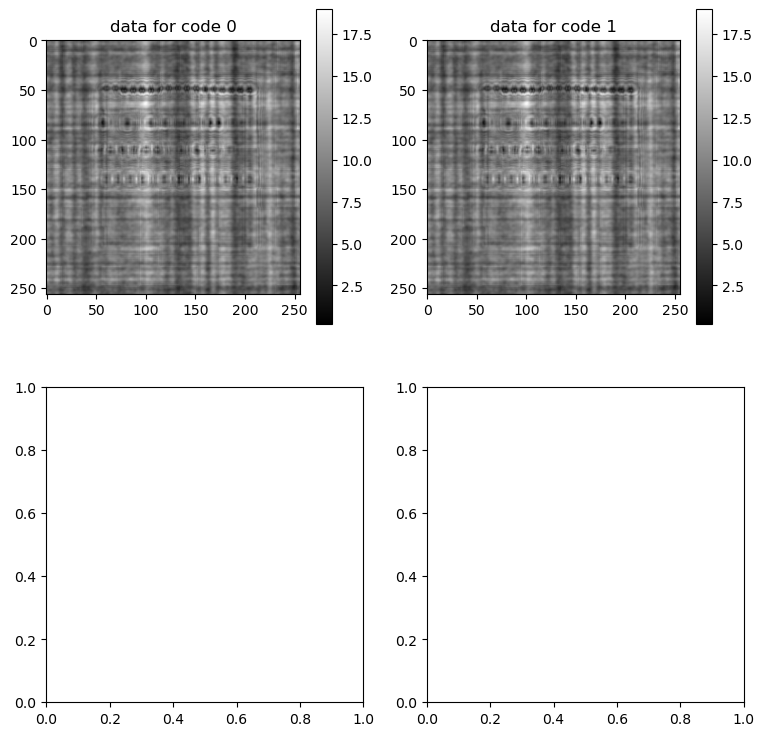

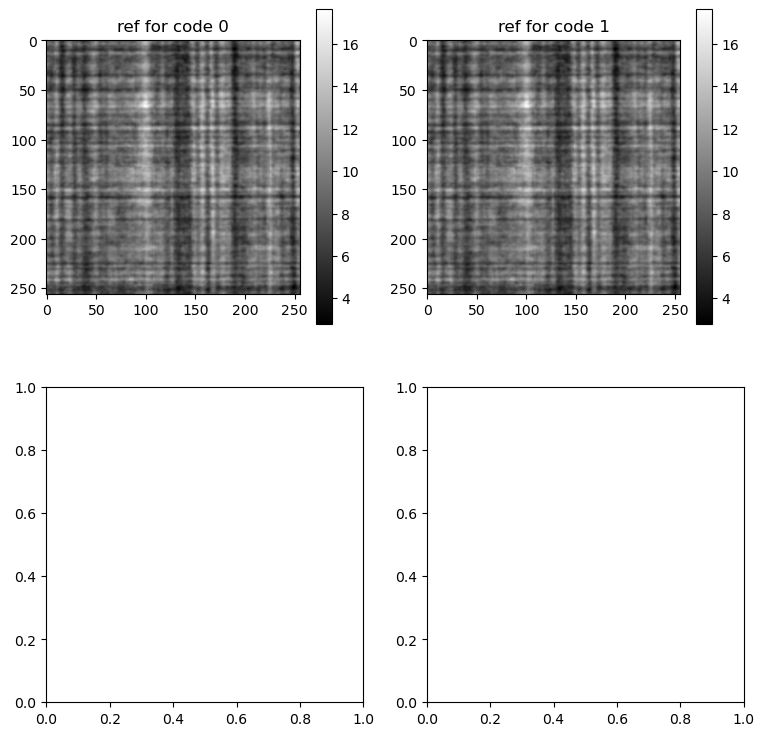

In [4]:
data0 = np.zeros([ndist,ntheta,n,n],dtype='float32')
ref0 = np.zeros([ndist,n,n],dtype='float32')
for k in range(ndist):
    print(f'/data/vnikitin/modeling/data_chip_codes_{n}_{k}.tiff')
    data0[k] = dxchange.read_tiff(f'/data/vnikitin/modeling/data_chip_codes_{n}_{k}.tiff')
    ref0[k] = dxchange.read_tiff(f'/data/vnikitin/modeling/ref_chip_codes_{n}_0.tiff')


#SQRT
data0=np.sqrt(data0)
ref0=np.sqrt(ref0)



fig, axs = plt.subplots(2, 2, figsize=(9, 9))
im=axs[0,0].imshow(data0[0,0],cmap='gray')
axs[0,0].set_title('data for code 0')
fig.colorbar(im)
im=axs[0,1].imshow(data0[-1,0],cmap='gray')
axs[0,1].set_title('data for code 1')
fig.colorbar(im)
plt.show()
fig, axs = plt.subplots(2, 2, figsize=(9, 9))
im=axs[0,0].imshow(ref0[0],cmap='gray')
axs[0,0].set_title('ref for code 0')
fig.colorbar(im)
im=axs[0,1].imshow(ref0[-1],cmap='gray')
axs[0,1].set_title('ref for code 1')
fig.colorbar(im)
plt.show()

## Read the transmittance functions for the code

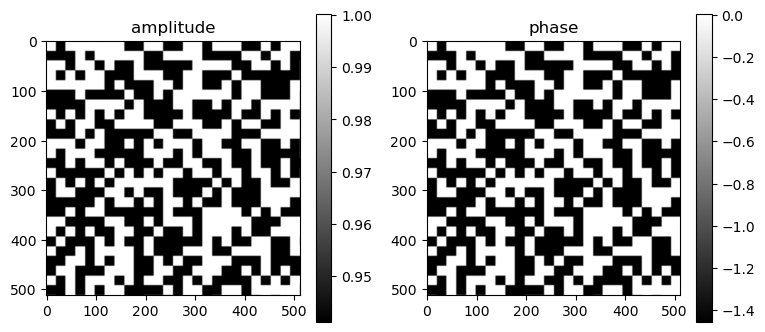

In [5]:
code = np.ones([1,2*n,2*n],dtype='complex64')
code[0] = (tifffile.imread(f'/data/vnikitin/modeling/psiill_abs_{n}.tiff')*np.exp(1j* tifffile.imread(f'/data/vnikitin/modeling/psiill_angle_{n}.tiff')))
fig, axs = plt.subplots(1, 2, figsize=(9, 4))
im=axs[0].imshow(np.abs(code[0]),cmap='gray')
axs[0].set_title('amplitude')
fig.colorbar(im)
im=axs[1].imshow(np.angle(code[0]),cmap='gray')
axs[1].set_title('phase')
fig.colorbar(im)

shifts = np.load(f'/data/vnikitin/modeling/shifts{n}.npy')
shifts_code = np.load(f'/data/vnikitin/modeling/shifts_code{n}.npy')


## Create a solver class for holography, note the class has additional parameters distances2 to be able to compute Fresnel propagation between the sample and probe

In [6]:
pslv = holotomo.SolverHolo(ntheta, n, ptheta, voxelsize, energy, distances, norm_magnifications, distancesp,pad=pad)
pslv0 = holotomo.SolverHolo(1, n, 1, voxelsize, energy, distances[:1], norm_magnifications[:1], distancesp[:1],pad=pad)


In [7]:
data = data0.copy()
ref = ref0.copy()
arr1 = np.pad(np.array(data[0]+1j*data[0]).astype('complex64'),((0,0),(ne//2-n//2,ne//2-n//2),(ne//2-n//2,ne//2-n//2)),'symmetric')

prb1 = np.array(ref[:]+1j*ref[:]).astype('complex64')
arr2 = pslv.fwd_holo_batch(arr1, prb1, code=code, shifts_code=shifts_code)
arr3 = pslv.adj_holo_batch(arr2, prb1, code=code, shifts_code=shifts_code)
prb3 = pslv.adj_holo_prb_batch(arr2,arr1, code=code, shifts_code=shifts_code)



print(np.sum(arr1*np.conj(arr3)))
print(np.sum(arr2*np.conj(arr2)))
print(np.sum(prb1*np.conj(prb3)))

(458926000000-6130.505j)
(458925050000+0.44423002j)
(458925150000-12704j)


## Conjugate gradient solver

In [8]:
import cupy as cp
def line_search(minf, gamma, fu, fu0, fd, fd0):
    """ Line search for the step sizes gamma"""
    while(minf(fu,fu0)-minf(fu+gamma*fd, fu0+gamma*fd0) < 0 and gamma > 1e-12):
        gamma *= 0.5
    if(gamma <= 1e-12):  # direction not found
        #print('no direction')
        gamma = 0
    return gamma

def cg_holo(pslv, pslv0, data, data_ref, init, init_prb,  piter,shifts, code=None, shifts_code=None, upd_psi=True, upd_prb=False,step=1,vis_step=1,gammapsi0=1,gammaprb0=2):
    """Conjugate gradients method for holography"""

    # minimization functional
    def minf(fpsi,fprb):
        f = cp.linalg.norm(cp.abs(fpsi)-data)**2            
        f += cp.linalg.norm(cp.abs(fprb)-data_ref)**2        
        return f        
    psi = init.copy()
    prb = init_prb.copy()
    gammapsi = gammapsi0
    gammaprb = gammaprb0
    psi_nil = psi[:1]*0+1
    shifts_nil = shifts[:,:1]*0
    shifts_code_nil = shifts_code[:,:1]*0
    
    for i in range(piter):
        if upd_psi:
            
            fpsi = pslv.fwd_holo(psi,prb,shifts,code, shifts_code)          
            d = -pslv.adj_holo(fpsi-data*cp.exp(1j*(cp.angle(fpsi))), prb,shifts,code, shifts_code)/cp.max(cp.abs(prb))**2#/ndist**2

            fd = pslv.fwd_holo(d, prb,shifts,code, shifts_code)     
            gammapsi = line_search(minf, gammapsi0, fpsi, 0, fd, 0)
            psi = psi+gammapsi*d
            
        if upd_prb:
            fprb = pslv.fwd_holo(psi,prb,shifts,code, shifts_code)
            fprb0 = pslv0.fwd_holo(psi_nil,prb,shifts_nil, code, shifts_code_nil)
            dprb = pslv.adj_holo_prb(fprb-data*cp.exp(1j*cp.angle(fprb)),psi,shifts,code, shifts_code)#/ndist**2
            dprb += pslv0.adj_holo_prb(fprb0-data_ref*cp.exp(1j*cp.angle(fprb0)),psi_nil,shifts_nil,code, shifts_code_nil)
            dprb*=-1/(pslv.ntheta+1)

            # line search
            fdprb = pslv.fwd_holo(psi, dprb,shifts,code, shifts_code)
            fdprb0 = pslv0.fwd_holo(psi_nil, dprb,shifts_nil,code, shifts_code_nil)
            
            gammaprb = line_search(minf, gammaprb0, fprb, fprb0, fdprb, fdprb0)
            prb = prb + gammaprb*dprb
            
        if i%step==0:
            fprb = pslv.fwd_holo(psi,prb,shifts,code, shifts_code)
            fprb0 = pslv0.fwd_holo(psi_nil,prb,shifts_nil,code, shifts_code_nil)            
            err=minf(fprb,fprb0)
            print(f'{i}) {gammapsi=} {gammaprb=}, {err=:1.5e}', flush=True)  

        if upd_prb==True and upd_psi==False and i%vis_step==0:  
            fig, axs = plt.subplots(1, 2, figsize=(10, 5))
            im=axs[0].imshow(cp.abs(prb[0]).get(),cmap='gray')
            axs[0].set_title('reconstructed amplitude')
            fig.colorbar(im)
            im=axs[1].imshow(cp.angle(prb[0]).get(),cmap='gray')
            axs[1].set_title('reconstructed phase')
            fig.colorbar(im)                
            plt.show()
        elif i%vis_step==0:  
            fig, axs = plt.subplots(1, 2, figsize=(10, 5))
            im=axs[0].imshow(cp.abs(psi[0]).get(),cmap='gray')
            axs[0].set_title('reconstructed amplitude')
            fig.colorbar(im)
            im=axs[1].imshow(cp.angle(psi[0]).get(),cmap='gray')
            axs[1].set_title('reconstructed phase')
            fig.colorbar(im)                
            plt.show()
            dxchange.write_tiff(cp.angle(psi).get(),f'/data/vnikitin/holo/chip_codes{flg}/{n}_{ntheta}_{ndist}/r{i:05}.tiff',overwrite=True)
            dxchange.write_tiff(cp.angle(psi[0]).get(),f'/data/vnikitin/holo/chip_codes{flg}/{n}_{ntheta}_{ndist}/o{i:05}.tiff',overwrite=True)
                        
            
    return psi,prb

def cg_holo_batch(pslv, pslv0, data,data_ref, init, prb_init, piter,shifts=None,code=None, shifts_code=None,upd_psi=True,upd_prb=False,step=1,vis_step=1,gammapsi0=1,gammaprb0=2):
    """Batch of CG solvers"""
    
    res = np.zeros([pslv.ntheta, pslv.ne, pslv.ne], dtype='complex64')
    prb_init_gpu = cp.array(prb_init)                
    codes_gpu = cp.array(code)
    for ids in holotomo.utils.chunk(range(pslv.ntheta), pslv.ptheta):
        # copy data part to gpu
        data_gpu = cp.array(data[:,ids])
        data_ref_gpu = cp.array(data_ref)
        
        init_gpu = cp.array(init[ids])
        shifts_gpu = cp.array(shifts[:,ids])        
        shift_codes_gpu = cp.array(shifts_code[:,ids])
        
        # Radon transform
        res_gpu,res_prb_gpu = cg_holo(pslv, pslv0, data_gpu,data_ref_gpu, init_gpu,prb_init_gpu, piter,shifts_gpu,codes_gpu,shift_codes_gpu,upd_psi, upd_prb,step,vis_step,gammapsi0,gammaprb0)
        # copy result to cpu
        res[ids] = res_gpu.get()
        res_prb = res_prb_gpu.get()
    return res,res_prb


def adj_holo_batch_ext(pslv,fpsi, data, prb, shifts=None, code=None, shifts_code=None,shifts_probe=None):
    """Batch of Holography transforms"""
    res = np.zeros([ntheta, pslv.ne, pslv.ne], dtype='complex64')
    prb_gpu = cp.array(prb)
    shifts_gpu = None        
    shifts_code_gpu = None
    code_gpu = None
    shifts_probe_gpu = None
    if code is not None:
        code_gpu = cp.array(code)   
    if shifts_probe is not None:
        shifts_probe_gpu = cp.array(shifts_probe)
    for ids in holotomo.utils.chunk(range(pslv.ntheta), pslv.ptheta):
        # copy data part to gpu
        fpsi_gpu = cp.array(fpsi[:, ids])
        data_gpu = cp.array(data[:, ids])
            
        if shifts is not None:
            shifts_gpu = cp.array(shifts[:,ids])
        if shifts_code is not None:
            shifts_code_gpu = cp.array(shifts_code[:,ids])
        fpsi_gpu = fpsi_gpu-data_gpu*cp.exp(1j*(np.angle(fpsi_gpu)))        
        # Radon transform
        res_gpu = -pslv.adj_holo(fpsi_gpu, prb_gpu, shifts_gpu, code_gpu, shifts_code_gpu,shifts_probe_gpu)
        # copy result to cpu
        res[ids] = res_gpu.get()
    return res

def adj_holo_prb_batch_ext(pslv, fpsi, data, psi, shifts=None, code=None, shifts_code=None,shifts_probe=None):
        """Batch of Holography transforms"""
        res = np.zeros([len(pslv.distances), pslv.n, pslv.n], dtype='complex64')
        shifts_gpu = None        
        shifts_code_gpu = None
        code_gpu = None
        shifts_probe_gpu = None
        if code is not None:
            code_gpu = cp.array(code)   
        if shifts_probe is not None:
            shifts_probe_gpu = cp.array(shifts_probe)
        for ids in holotomo.utils.chunk(range(pslv.ntheta), pslv.ptheta):
            # copy data part to gpu
            fpsi_gpu = cp.array(fpsi[:, ids])
            psi_gpu = cp.array(psi[ids])
            data_gpu = cp.array(data[:, ids])
            
            if shifts is not None:
                shifts_gpu = cp.array(shifts[:,ids])
            if shifts_code is not None:
                shifts_code_gpu = cp.array(shifts_code[:,ids])
            # Radon transform
            fpsi_gpu = fpsi_gpu-data_gpu*cp.exp(1j*(np.angle(fpsi_gpu)))                
            # fprb-data*np.exp(1j*np.angle(fprb))
            res_gpu = -pslv.adj_holo_prb(fpsi_gpu, psi_gpu, shifts_gpu,code_gpu,shifts_code_gpu,shifts_probe_gpu)
            # copy result to cpu
            res += res_gpu.get()
        return res

def cg_holo_batch2(pslv, pslv0, data,data_ref, init, prb_init, piter,  \
                      shifts=None,code=None, shifts_code=None,upd_psi=True,upd_prb=True,\
                        step=1,vis_step=1,gammapsi0=1,gammaprb0=2):
    """Conjugate gradients method for holography"""

    # minimization functional
    def minf(fpsi,fprb):
        f = np.linalg.norm(np.abs(fpsi)-data)**2            
        f += np.linalg.norm(np.abs(fprb)-data_ref)**2        
        return f        
    
    psi = init.copy()
    prb = prb_init.copy()
    gammapsi = gammapsi0
    gammaprb = gammaprb0
    
    
    psi_nil = psi[:1]*0+1
    shifts_nil = shifts[:1]*0+1
    shifts_code_nil = shifts_code[:,0:1]*0
    
    for i in range(piter):
        if upd_psi:
            fpsi = pslv.fwd_holo_batch(psi,prb,shifts,code,shifts_code)          
            d = adj_holo_batch_ext(pslv,fpsi,data, prb,shifts,code,shifts_code)/np.max(np.abs(prb))**2
            
            # line search
            fd = pslv.fwd_holo_batch(d, prb,shifts,code,shifts_code)             
            gammapsi = line_search(minf, gammapsi0, fpsi, 0, fd, 0)       
            psi = psi+gammapsi*d
            
        if upd_prb:
            fprb = pslv.fwd_holo_batch(psi,prb,shifts,code,shifts_code)
            fprb0 = pslv0.fwd_holo_batch(psi_nil,prb,shifts_nil,code,shifts_code_nil)            
            dprb = adj_holo_prb_batch_ext(pslv,fprb,data,psi,shifts,code,shifts_code)#/ndist**2            
            dprb += adj_holo_prb_batch_ext(pslv0,fprb0,data_ref,psi_nil,shifts_nil,code,shifts_code_nil)
            dprb *= 1/(pslv.ntheta+1)

            # line search
            fdprb = pslv.fwd_holo_batch(psi, dprb,shifts,code,shifts_code) 
            fdprb0 = pslv0.fwd_holo_batch(psi_nil, dprb,shifts_nil,code,shifts_code_nil) 
            
            gammaprb = line_search(minf, gammaprb0, fprb, fprb0, fdprb, fdprb0)
            
            prb = prb + gammaprb*dprb                    
        if i%step==0:
            fprb = pslv.fwd_holo_batch(psi,prb,shifts,code, shifts_code)
            fprb0 = pslv0.fwd_holo_batch(psi_nil,prb,shifts_nil,code, shifts_code_nil)            
            err=minf(fprb,fprb0)
            print(f'{i}) {gammapsi=} {gammaprb=}, {err=:1.5e}', flush=True)  
        if i%vis_step==0:  
            fig, axs = plt.subplots(1, 2, figsize=(10, 5))
            im=axs[0].imshow(np.abs(psi[0]),cmap='gray')
            axs[0].set_title('reconstructed abs')
            fig.colorbar(im)
            im=axs[1].imshow(np.angle(psi[0]),cmap='gray')
            axs[1].set_title('reconstructed phase')
            fig.colorbar(im)                
            plt.show()
    return psi,prb

0) gammapsi=0.5 gammaprb=1, err=4.91062e+04


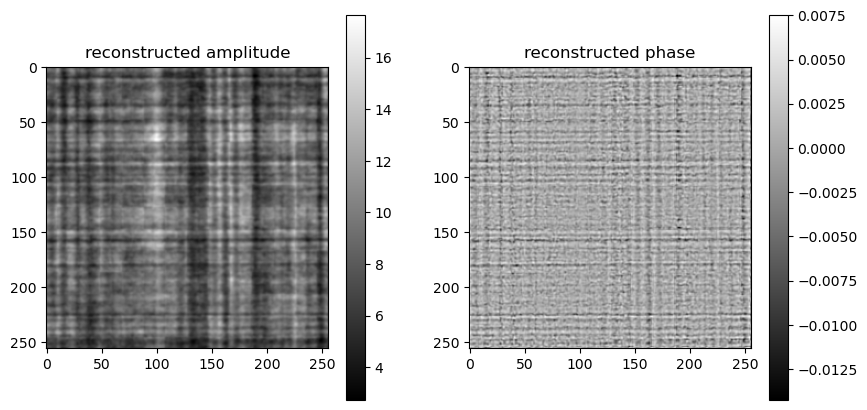

16) gammapsi=0.5 gammaprb=1, err=3.71046e-07
32) gammapsi=0.5 gammaprb=1, err=4.24722e-07


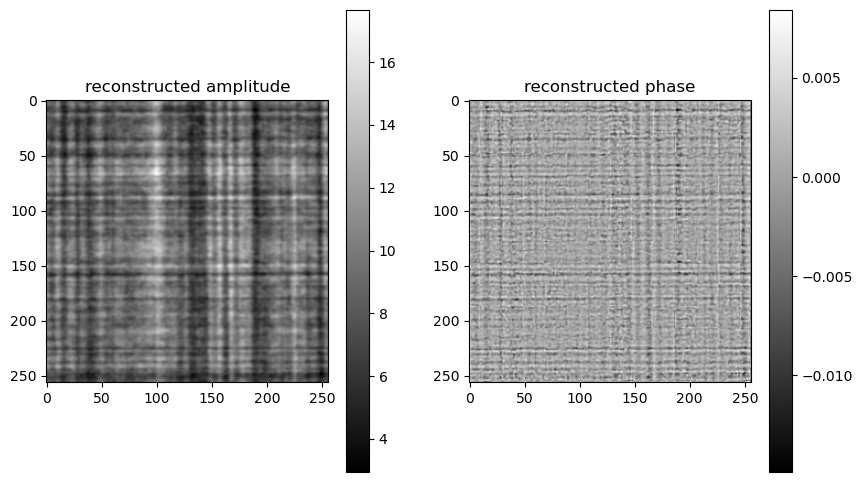

In [9]:
pslv = holotomo.SolverHolo(ntheta, n, ptheta, voxelsize, energy, distances, norm_magnifications, distancesp,pad=pad)
pslv0 = holotomo.SolverHolo(1, n, 1, voxelsize, energy, distances, norm_magnifications, distancesp,pad=pad)

rec = np.ones([1,ne,ne],dtype='complex64')
rec_prb = np.ones([ndist,n,n],dtype='complex64')        
data_ref = ref[:,np.newaxis]
shifts_ref = np.array(shifts)[:,:1]*0
shifts_codes_ref = np.array(shifts_code)[:,:1]*0
_,rec_prb0 = cg_holo_batch(pslv0, pslv0, data_ref, data_ref, rec, rec_prb, 33, shifts_ref, code, shifts_codes_ref, False,True,16,35,0.5,1)

fig, axs = plt.subplots(1, 2, figsize=(10, 6))
im=axs[0].imshow(np.abs(rec_prb0[0]),cmap='gray')
axs[0].set_title('reconstructed amplitude')
fig.colorbar(im)
im=axs[1].imshow(np.angle(rec_prb0[0]),cmap='gray')
axs[1].set_title('reconstructed phase')
fig.colorbar(im)

0) gammapsi=1 gammaprb=2, err=1.36796e+06


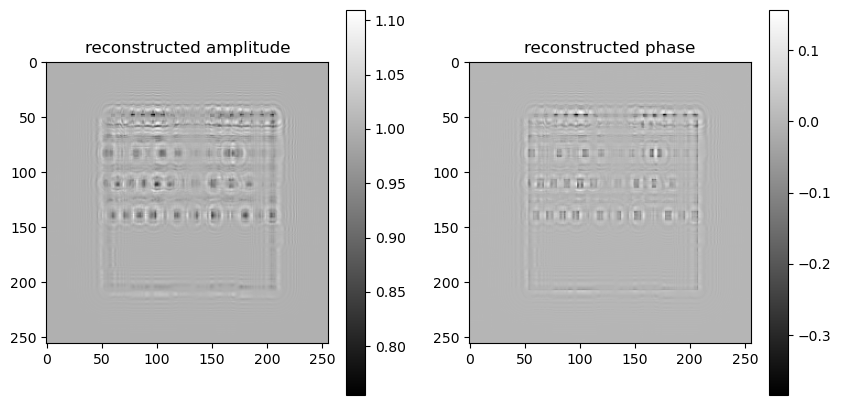

32) gammapsi=1 gammaprb=2, err=6.48076e+03


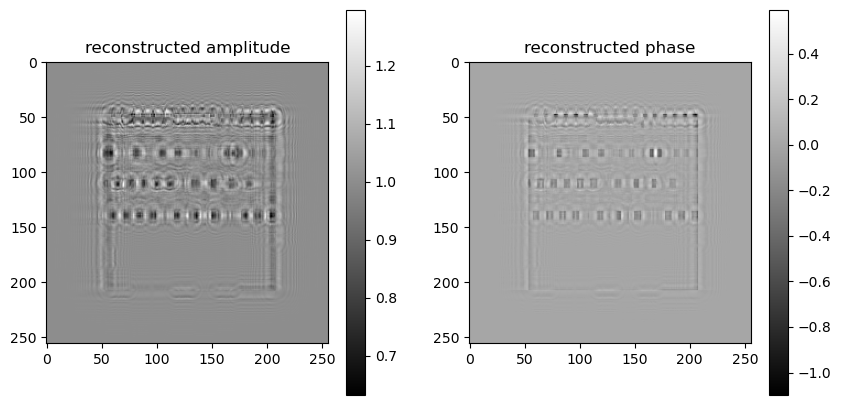

64) gammapsi=1 gammaprb=2, err=5.94717e+03


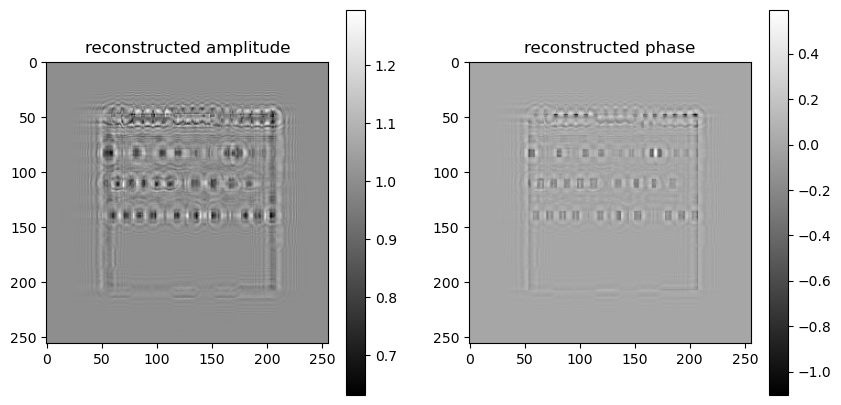

In [10]:
shifts_rec = cp.array(shifts/norm_magnifications[:,np.newaxis,np.newaxis])
rec1 = np.ones([ntheta,ne,ne],dtype='complex64')
# # use only the abs value of the probe as initial guess
rec_prb1 = rec_prb0.copy()
rec1,rec_prb1 = cg_holo_batch(pslv, pslv0, data, data_ref, rec1, rec_prb1, 65, shifts_rec, code, shifts_code, True,True,32,32,1,2)


In [11]:
def line_search_ext(minf, gamma, u, fu, fu0, d, fd, fd0):
    """ Line search for the step sizes gamma"""
    while(minf(u,fu,fu0)-minf(u+gamma*d, fu+gamma*fd, fu0+gamma*fd0) < 0 and gamma > 1e-12):
        gamma *= 0.5
    if(gamma <= 1e-12):  # direction not found
        #print('no direction')
        gamma = 0
    return gamma

def line_search(minf, gamma, u, fu, d, fd):

    """ Line search for the step sizes gamma"""

    while(minf(u, fu)-minf(u+gamma*d, fu+gamma*fd) < 0 and gamma > 1e-12):
        gamma *= 0.5
    if(gamma <= 1e-12):  # direction not found
        #print('no direction')
        gamma = 0
    return gamma

def cg_holo_ext(pslv, pslv0, data, data_ref, init, init_prb,  piter, h, lamd, rho, \
                shifts=None, code=None, shifts_code=None, upd_psi=True, upd_prb=False,\
                step=1,vis_step=1,gammapsi0=1,gammaprb0=2):
    """Conjugate gradients method for holography"""

    # minimization functional
    def minf(psi,fpsi,fprb):
        f = cp.linalg.norm(cp.abs(fpsi)-data)**2            
        f += cp.linalg.norm(cp.abs(fprb)-data_ref)**2      
        f += rho*cp.linalg.norm(h-psi+lamd/rho)**2        
        return f        
    psi = init.copy()
    prb = init_prb.copy()
    gammapsi = gammapsi0
    gammaprb = gammaprb0
    
    psi_nil = psi[:1]*0+1
    shifts_nil = shifts[:,:1]*0
    shifts_code_nil = shifts_code[:,0:1]*0
    
    for i in range(piter):
        if upd_psi:
            
            fpsi = pslv.fwd_holo(psi,prb,shifts,code, shifts_code)          
            d = -pslv.adj_holo(fpsi-data*cp.exp(1j*(cp.angle(fpsi))), prb,shifts,code, shifts_code)/cp.max(cp.abs(prb))**2#/ndist**2
            d += rho*(h - psi + lamd/rho)

            # fd = pslv.fwd_holo(d, prb,shifts,code, shifts_code)     
            gammapsi = gammapsi0#line_search_ext(minf, gammapsi0, psi, fpsi, 0, d, fd, 0)
            psi = psi+gammapsi*d
            
        if upd_prb:
            fprb = pslv.fwd_holo(psi,prb,shifts,code, shifts_code)
            fprb0 = pslv0.fwd_holo(psi_nil,prb,shifts_nil, code, shifts_code_nil)
            dprb = pslv.adj_holo_prb(fprb-data*cp.exp(1j*cp.angle(fprb)),psi,shifts,code, shifts_code)#/ndist**2
            dprb += pslv0.adj_holo_prb(fprb0-data_ref*cp.exp(1j*cp.angle(fprb0)),psi_nil,shifts_nil,code, shifts_code_nil)
            dprb*=-1/(pslv.ntheta+1)

            # line search
            # fdprb = pslv.fwd_holo(psi, dprb,shifts,code, shifts_code)
            # fdprb0 = pslv0.fwd_holo(psi_nil, dprb,shifts_nil,code, shifts_code_nil)
            
            #PLEASE CHECK!!!
            gammaprb = gammaprb0#line_search_ext(minf, gammaprb0, psi, fprb, fprb0, 0, fdprb, fdprb0)
            prb = prb + gammaprb*dprb
            
        # if i%step==0:
        #     fprb = pslv.fwd_holo(psi,prb,shifts,code, shifts_code)
        #     fprb0 = pslv0.fwd_holo(psi_nil,prb,shifts_nil,code, shifts_code_nil)            
        #     err=minf(psi,fprb,fprb0)
        #     print(f'{i}) {gammapsi=} {gammaprb=}, {err=:1.5e}', flush=True)                                    
    
    return psi,prb

def cg_holo_batch_ext(pslv, pslv0, data,data_ref, init, prb_init, piter, h, lamd, rho, \
                      shifts=None,code=None, shifts_code=None,upd_psi=True,upd_prb=False,\
                        step=1,vis_step=1,gammapsi0=1,gammaprb0=2):
    """Batch of CG solvers"""
    
    res = np.zeros([pslv.ntheta, pslv.ne, pslv.ne], dtype='complex64')
    prb_init_gpu = cp.array(prb_init)                
    codes_gpu = cp.array(code)
    for ids in holotomo.utils.chunk(range(pslv.ntheta), pslv.ptheta):
        # copy data part to gpu
        data_gpu = cp.array(data[:,ids])
        data_ref_gpu = cp.array(data_ref)
        
        init_gpu = cp.array(init[ids])
        h_gpu = cp.array(h[ids])
        lamd_gpu = cp.array(lamd[ids])
        shifts_gpu = cp.array(shifts[:,ids])        
        shift_codes_gpu = cp.array(shifts_code[:,ids])
        
        # Radon transform
        res_gpu,res_prb_gpu = cg_holo_ext(pslv, pslv0, data_gpu,data_ref_gpu, init_gpu,prb_init_gpu, piter,h_gpu, lamd_gpu, rho, \
                                      shifts_gpu,codes_gpu,shift_codes_gpu,upd_psi, upd_prb,step,vis_step,gammapsi0,gammaprb0)
        # copy result to cpu
        res[ids] = res_gpu.get()
        res_prb = res_prb_gpu.get()
    return res,res_prb


def adj_holo_batch_ext(pslv,fpsi, data, prb, shifts=None, code=None, shifts_code=None,shifts_probe=None):
    """Batch of Holography transforms"""
    res = np.zeros([ntheta, pslv.ne, pslv.ne], dtype='complex64')
    prb_gpu = cp.array(prb)
    shifts_gpu = None        
    shifts_code_gpu = None
    code_gpu = None
    shifts_probe_gpu = None
    if code is not None:
        code_gpu = cp.array(code)   
    if shifts_probe is not None:
        shifts_probe_gpu = cp.array(shifts_probe)
    for ids in holotomo.utils.chunk(range(pslv.ntheta), pslv.ptheta):
        # copy data part to gpu
        fpsi_gpu = cp.array(fpsi[:, ids])
        data_gpu = cp.array(data[:, ids])
            
        if shifts is not None:
            shifts_gpu = cp.array(shifts[:,ids])
        if shifts_code is not None:
            shifts_code_gpu = cp.array(shifts_code[:,ids])
        fpsi_gpu = fpsi_gpu-data_gpu*cp.exp(1j*(np.angle(fpsi_gpu)))        
        # Radon transform
        res_gpu = -pslv.adj_holo(fpsi_gpu, prb_gpu, shifts_gpu, code_gpu, shifts_code_gpu,shifts_probe_gpu)
        # copy result to cpu
        res[ids] = res_gpu.get()
    return res

def adj_holo_prb_batch_ext(pslv, fpsi, data, psi, shifts=None, code=None, shifts_code=None,shifts_probe=None):
        """Batch of Holography transforms"""
        res = np.zeros([len(pslv.distances), pslv.n, pslv.n], dtype='complex64')
        shifts_gpu = None        
        shifts_code_gpu = None
        code_gpu = None
        shifts_probe_gpu = None
        if code is not None:
            code_gpu = cp.array(code)   
        if shifts_probe is not None:
            shifts_probe_gpu = cp.array(shifts_probe)
        for ids in holotomo.utils.chunk(range(pslv.ntheta), pslv.ptheta):
            # copy data part to gpu
            fpsi_gpu = cp.array(fpsi[:, ids])
            psi_gpu = cp.array(psi[ids])
            data_gpu = cp.array(data[:, ids])
            
            if shifts is not None:
                shifts_gpu = cp.array(shifts[:,ids])
            if shifts_code is not None:
                shifts_code_gpu = cp.array(shifts_code[:,ids])
            fpsi_gpu = fpsi_gpu-data_gpu*cp.exp(1j*(np.angle(fpsi_gpu)))                
            res_gpu = -pslv.adj_holo_prb(fpsi_gpu, psi_gpu, shifts_gpu,code_gpu,shifts_code_gpu,shifts_probe_gpu)
            # copy result to cpu
            res += res_gpu.get()
        return res

def cg_holo_batch2_ext(pslv, pslv0, data,data_ref, init, prb_init, piter, h, lamd, rho, \
                      shifts=None,code=None, shifts_code=None,upd_psi=True,upd_prb=False,\
                        step=1,vis_step=1,gammapsi0=1,gammaprb0=2):
    """Conjugate gradients method for holography"""

    # minimization functional
    def minf(psi,fpsi,fprb):
        f = np.linalg.norm(np.abs(fpsi)-data)**2            
        f += np.linalg.norm(np.abs(fprb)-data_ref)**2        
        f += rho*np.linalg.norm(h-psi+lamd/rho)**2     
        return f        
    
    psi = init.copy()
    prb = prb_init.copy()
    gammapsi = gammapsi0
    gammaprb = gammaprb0
    
    
    psi_nil = psi*0+1
    shifts_nil = shifts*0+1
    shifts_code_nil = shifts_code[:,0:1]*0
    
    for i in range(piter):
        if upd_psi:
            fpsi = pslv.fwd_holo_batch(psi,prb,shifts,code,shifts_code)          
            d = adj_holo_batch_ext(pslv,fpsi,data, prb,shifts,code,shifts_code)/np.max(np.abs(prb))**2
            d += rho*(h - psi + lamd/rho)
         
            # line search
            #fd = pslv.fwd_holo_batch(d, prb,shifts,code,shifts_code)             
            gammapsi = gammapsi0#line_search_ext(minf, gammapsi0, psi, fpsi, 0, d, fd, 0)       
            psi = psi+gammapsi*d
            
        if upd_prb:
            fprb = pslv.fwd_holo_batch(psi,prb,shifts,code,shifts_code)
            fprb0 = pslv0.fwd_holo_batch(psi_nil,prb,shifts_nil,code,shifts_code_nil)            
            dprb = adj_holo_prb_batch_ext(pslv,fprb,data,psi,shifts,code,shifts_code)#/ndist**2            
            dprb += adj_holo_prb_batch_ext(pslv0,fprb0,data_ref,psi_nil,shifts_nil,code,shifts_code_nil)
            dprb *= 1/(pslv.ntheta+1)

            # line search
            #fdprb = pslv.fwd_holo_batch(psi, dprb,shifts,code,shifts_code) 
            #fdprb0 = pslv0.fwd_holo_batch(psi_nil, dprb,shifts_nil,code,shifts_code_nil) 
            
            gammaprb = gammaprb0#line_search_ext(minf, gammaprb0, psi, fprb, fprb0, 0, fdprb, fdprb0)
            
            prb = prb + gammaprb*dprb                    
                   
    return psi,prb

def take_lagr(pslv,pslv0, psi,prb, data, data_ref,shifts, code, shifts_code, h, lamd,rho):
    lagr = np.zeros(5, dtype="float32")

    fpsi = pslv.fwd_holo_batch(psi,prb,shifts, code, shifts_code)    
    lagr[0] = np.linalg.norm(np.abs(fpsi)-data)**2            

    psi_nil = psi*0+1
    shifts_nil = shifts*0
    shifts_code_nil = shifts_code[:,0:1]*0
    fprb = pslv0.fwd_holo_batch(psi_nil,prb, shifts_nil, code, shifts_code_nil)            
    lagr[1] = np.linalg.norm(np.abs(fprb)-data_ref)**2      

    lagr[2] = 2*np.sum(np.real(np.conj(lamd)*(h-psi)))
    
    lagr[3] = rho*cp.linalg.norm(h-psi)**2    

    lagr[4] = cp.sum(lagr[0:4])

    return lagr
def take_lagr_gpu(pslv,pslv0, psi, prb, data, data_ref, shifts, code, shifts_code, h, lamd,rho):
    lagr = cp.zeros(5, dtype="float32")
    fpsi = pslv.fwd_holo(psi,prb,shifts, code, shifts_code)    
    lagr[0] = cp.linalg.norm(np.abs(fpsi)-data)**2            

    psi_nil = psi[:1]*0+1
    shifts_nil = shifts[:,:1]*0
    shifts_code_nil = shifts_code[:,0:1]*0
    fprb = pslv0.fwd_holo(psi_nil,prb, shifts_nil, code, shifts_code_nil)            
    lagr[1] = cp.linalg.norm(cp.abs(fprb)-data_ref)**2      

    lagr[2] = 2*cp.sum(cp.real(cp.conj(lamd)*(h-psi)))
    
    lagr[3] = rho*cp.linalg.norm(h-psi)**2    

    lagr[4] = cp.sum(lagr[0:4])

    return lagr

def update_penalty(psi, h, h0, rho):
    # rho
    r = np.linalg.norm(psi - h)**2
    s = np.linalg.norm(rho*(h-h0))**2
    if (r > 10*s):
        rho *= 2
    elif (s > 10*r):
        rho *= 0.5
    
    return rho
def admm(pslv, pslv0, tslv, data,data_ref, h, psi, prb, shifts, code, shifts_code, lamd, u, piter, titer, niter,step=1,viz_step=1):
    rho = 0.5
    for m in range(niter):
        # keep previous iteration for penalty updates
        # h0 = h.copy()
        psi,prb = cg_holo_batch2_ext(pslv, pslv0, data, data_ref, psi, prb, piter,h, lamd,rho,\
                                shifts,code,shifts_code,True,True,1,1,0.5,1)
                                #1,1,1,2)
        xi = pslv.logtomo(psi-lamd/rho)
        # tomography problem
        u = tslv.cg_tomo_batch(xi, u, titer, 0.5)
        # h,e updates        
        h = pslv.exptomo(tslv.fwd_tomo_batch(u))
        # lambda, mu updates
        lamd = lamd + rho * (h-psi)
                
        if m%viz_step==0:
            fig, axs = plt.subplots(1, 2, figsize=(10, 5))
            im=axs[0].imshow(np.real(u[:,ne//2]), cmap='gray')
            axs[0].set_title('reconstructed amplitude')
            fig.colorbar(im)
            im=axs[1].imshow(np.angle(psi[0]), cmap='gray')
            axs[1].set_title('reconstructed phase')
            fig.colorbar(im)                
            plt.show()
            dxchange.write_tiff(np.angle(psi),   f'/data/vnikitin/modeling/chip_codes{flg}/psi/r{m:05}.tiff',overwrite=True)
            dxchange.write_tiff(np.angle(psi[0]),f'/data/vnikitin/modeling/chip_codes{flg}/psi/o{m:05}.tiff',overwrite=True)
            dxchange.write_tiff(np.imag(u),      f'/data/vnikitin/modeling/chip_codes{flg}/uim/r{m:05}.tiff',overwrite=True)
            dxchange.write_tiff(np.imag(u[53]), f'/data/vnikitin/modeling/chip_codes{flg}/uim/o{m:05}.tiff',overwrite=True)
            dxchange.write_tiff(np.real(u),      f'/data/vnikitin/modeling/chip_codes{flg}/ure/r{m:05}.tiff',overwrite=True)
            dxchange.write_tiff(np.real(u[53]), f'/data/vnikitin/modeling/chip_codes{flg}/ure/o{m:05}.tiff',overwrite=True)
        # Lagrangians difference between two iterations
        if m%step==0:
            lagr = take_lagr(pslv,pslv0, psi,prb, data, data_ref,shifts, code,shifts_code, h, lamd,rho)
            print("%d/%d) rho=%f, %.2e %.2e %.2e %.2e, Sum: %.2e" %(m, niter, rho, *lagr))
        
        # rho = update_penalty(psi,h,h0,rho)
    return u, psi, prb
def admm_gpu(pslv, pslv0, tslv, data,data_ref, h, psi, prb,shifts, code, shifts_code, lamd, u, piter, titer, niter,step=1,viz_step=1):
    rho = 0.5    
    for m in range(niter):
        # keep previous iteration for penalty updates
        # h0 = h.copy()
        psi,prb = cg_holo_ext(pslv, pslv0, data, data_ref, psi, prb, piter,h, lamd,rho,\
                                shifts,code,shifts_code,True,True,1,1,1,2)
                                #1,1,1,2)
        xi = pslv.logtomo(psi-lamd/rho)
        # tomography problem
        u = tslv.cg_tomo(xi, u, titer, 1)
        # h,e updates        
        h = pslv.exptomo(tslv.fwd_tomo(u))
        # lambda, mu updates
        lamd += rho * (h-psi)
                
        if m%viz_step==0:
            fig, axs = plt.subplots(1, 2, figsize=(10, 5))
            im=axs[0].imshow(cp.real(u[:,ne//2]).get(), cmap='gray')
            axs[0].set_title('reconstructed amplitude')
            fig.colorbar(im)
            im=axs[1].imshow(cp.angle(psi[0]).get(), cmap='gray')
            axs[1].set_title('reconstructed phase')
            fig.colorbar(im)                
            plt.show()
            dxchange.write_tiff(cp.angle(psi).get(),   f'/data/vnikitin/modeling/chip_codes{flg}/psi/r{m:05}.tiff',overwrite=True)
            dxchange.write_tiff(cp.angle(psi[0]).get(),f'/data/vnikitin/modeling/chip_codes{flg}/psi/o{m:05}.tiff',overwrite=True)
            dxchange.write_tiff(cp.imag(u).get(),      f'/data/vnikitin/modeling/chip_codes{flg}/uim/r{m:05}.tiff',overwrite=True)
            dxchange.write_tiff(cp.imag(u[57*n//256]).get(), f'/data/vnikitin/modeling/chip_codes{flg}/uim/o{m:05}.tiff',overwrite=True)
            dxchange.write_tiff(cp.real(u).get(),      f'/data/vnikitin/modeling/chip_codes{flg}/ure/r{m:05}.tiff',overwrite=True)
            dxchange.write_tiff(cp.real(u[57*n//256]).get(), f'/data/vnikitin/modeling/chip_codes{flg}/ure/o{m:05}.tiff',overwrite=True)
        # Lagrangians difference between two iterations
        if m%step==0:            
            lagr = take_lagr_gpu(pslv,pslv0, psi,prb, data, data_ref, shifts, code, shifts_code,h, lamd,rho)
            print("%d/%d) rho=%f, %.2e %.2e %.2e %.2e, Sum: %.2e" %(m, niter, rho, *lagr))
        
        # rho = update_penalty(psi,h,h0,rho)
    return u, psi, prb

In [12]:
# tslv = holotomo.SolverTomo(theta, ntheta, ne, ne, pn*ne//n, center*ne//n)

# h = np.ones([ntheta,ne,ne],dtype='complex64')
# lamd = np.zeros([ntheta,ne,ne],dtype='complex64')
# rec = np.ones([ntheta,ne,ne],dtype='complex64')
# rec_prb = rec_prb1.copy()
# urec = np.zeros([ne,ne,ne],dtype='complex64')
# urec, rec, rec_prb = admm(pslv, pslv0, tslv, data, data_ref, h, rec, rec_prb, shifts,code,shifts_code, lamd, urec, 4, 1, 1,1,1)


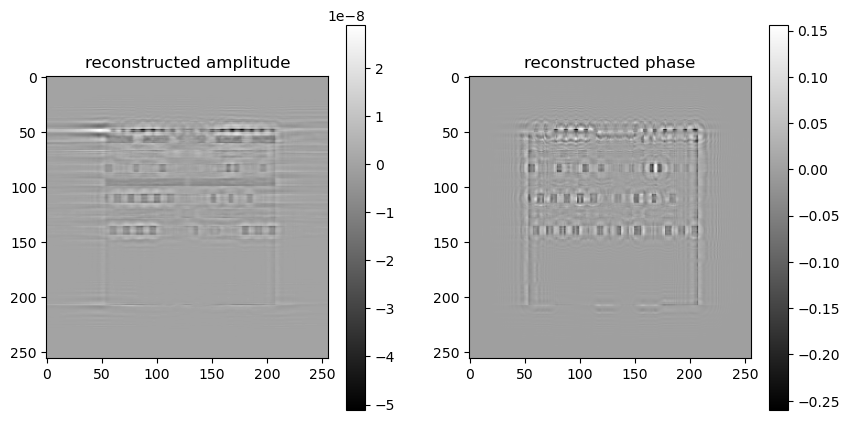

0/2048) rho=0.500000, 3.64e+05 1.05e+04 7.55e+02 3.78e+02, Sum: 3.76e+05


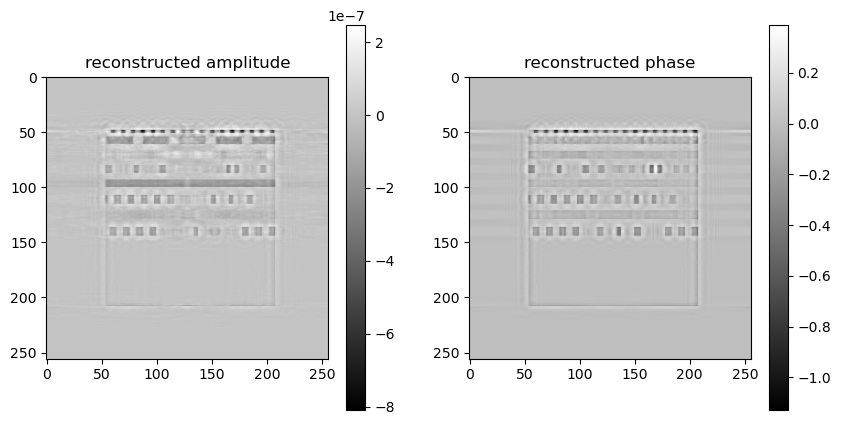

32/2048) rho=0.500000, 5.95e+04 1.77e+03 -2.14e+00 9.30e-01, Sum: 6.13e+04


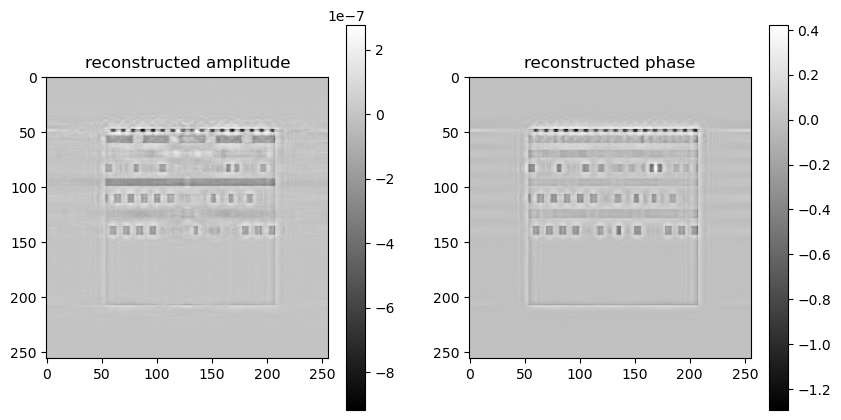

64/2048) rho=0.500000, 2.94e+04 8.16e+02 -5.96e-01 1.91e-01, Sum: 3.03e+04


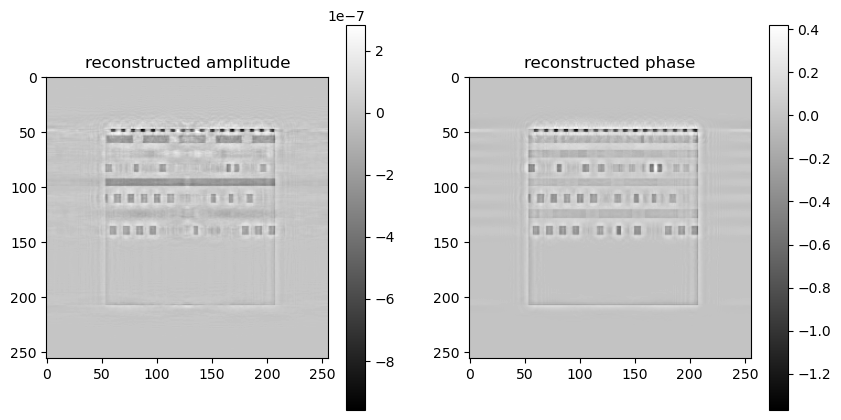

96/2048) rho=0.500000, 1.94e+04 4.90e+02 -2.55e-01 9.62e-02, Sum: 1.99e+04


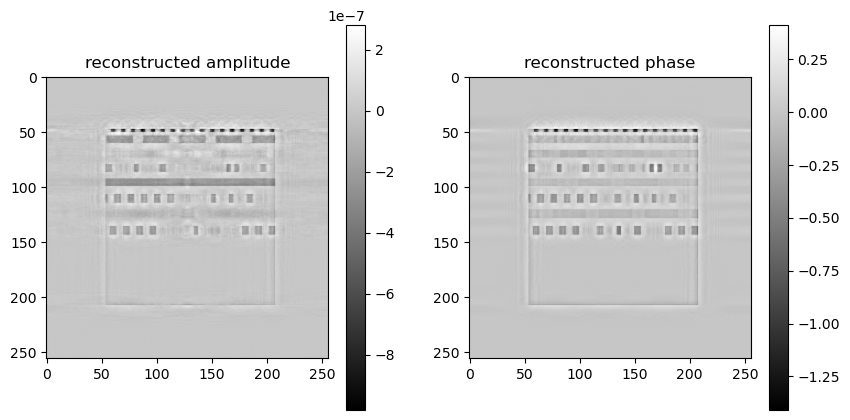

128/2048) rho=0.500000, 1.44e+04 3.38e+02 -1.34e-01 6.15e-02, Sum: 1.47e+04


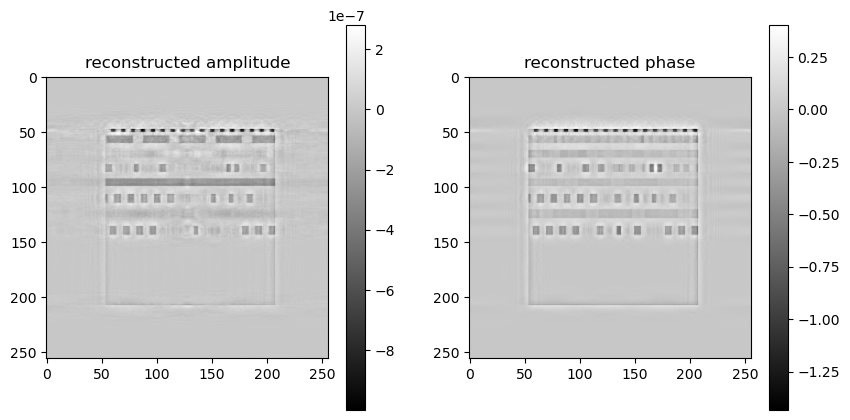

160/2048) rho=0.500000, 1.14e+04 2.54e+02 -8.08e-02 4.34e-02, Sum: 1.17e+04


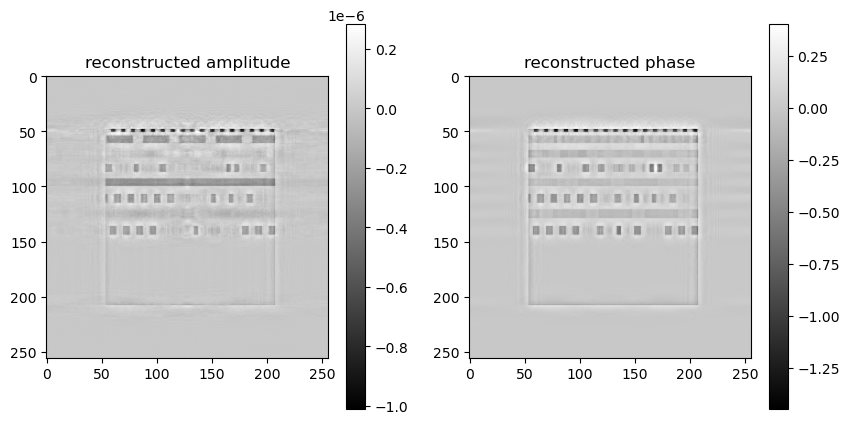

192/2048) rho=0.500000, 9.47e+03 2.03e+02 -5.30e-02 3.25e-02, Sum: 9.67e+03


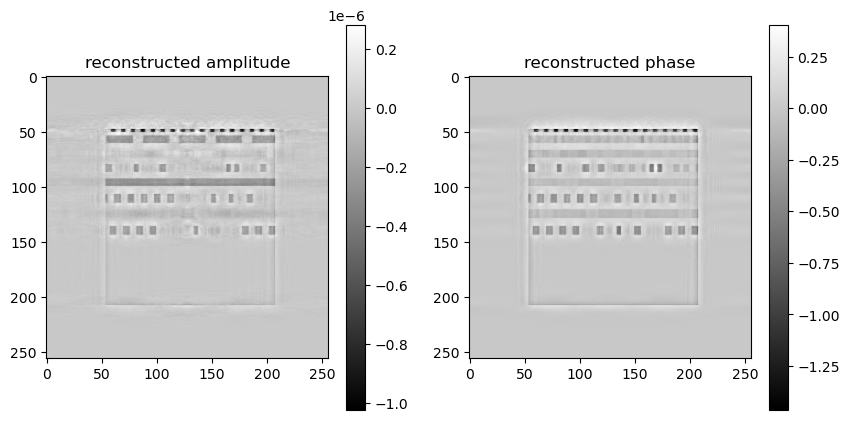

224/2048) rho=0.500000, 8.08e+03 1.70e+02 -3.70e-02 2.55e-02, Sum: 8.25e+03


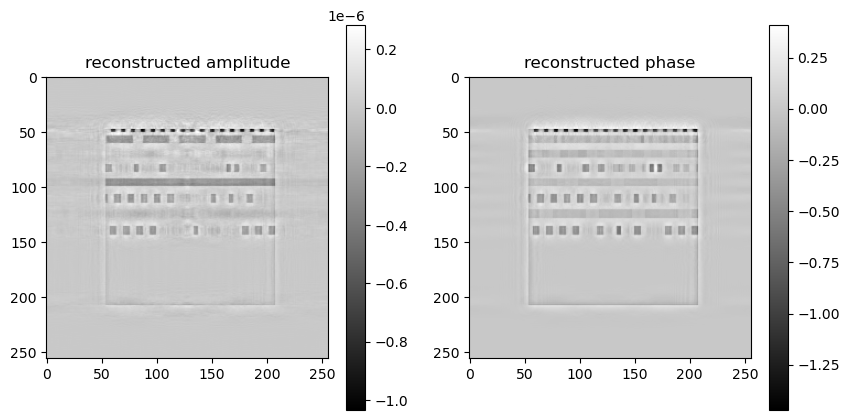

256/2048) rho=0.500000, 7.04e+03 1.46e+02 -2.71e-02 2.06e-02, Sum: 7.18e+03


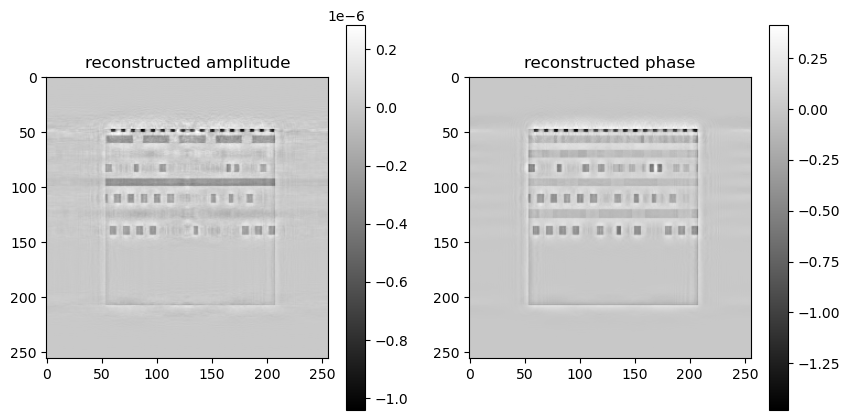

288/2048) rho=0.500000, 6.23e+03 1.29e+02 -2.05e-02 1.72e-02, Sum: 6.36e+03


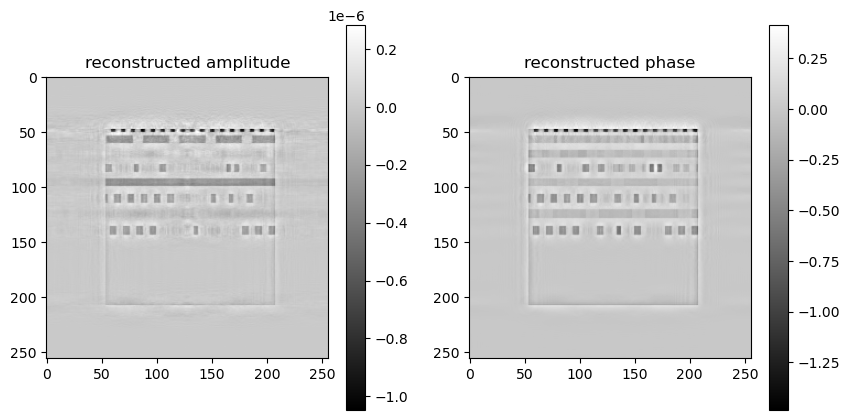

320/2048) rho=0.500000, 5.59e+03 1.17e+02 -1.59e-02 1.48e-02, Sum: 5.70e+03


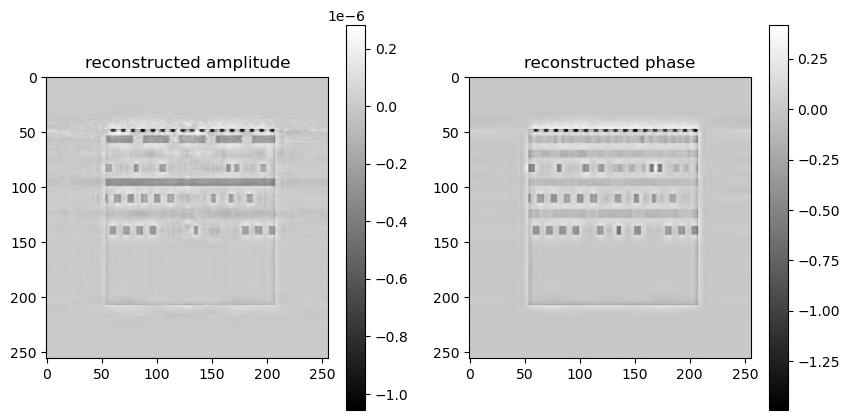

352/2048) rho=0.500000, 5.06e+03 1.07e+02 -1.26e-02 1.29e-02, Sum: 5.16e+03


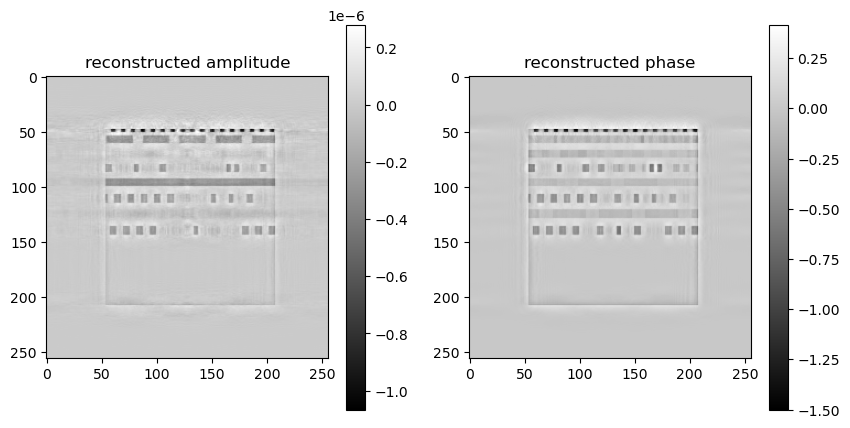

384/2048) rho=0.500000, 4.61e+03 9.91e+01 -1.01e-02 1.16e-02, Sum: 4.71e+03


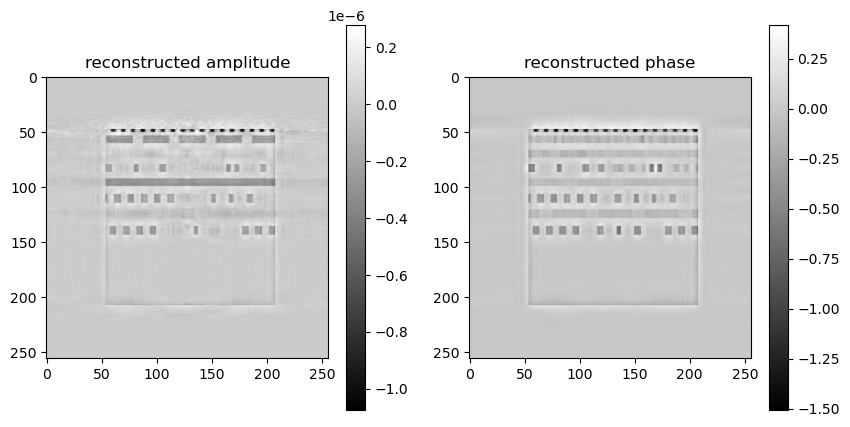

416/2048) rho=0.500000, 4.23e+03 9.28e+01 -8.17e-03 1.05e-02, Sum: 4.33e+03


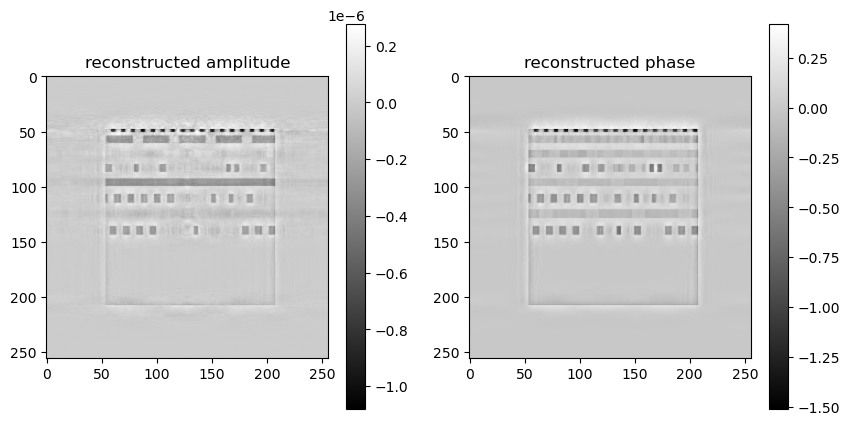

448/2048) rho=0.500000, 3.90e+03 8.77e+01 -6.63e-03 9.66e-03, Sum: 3.99e+03


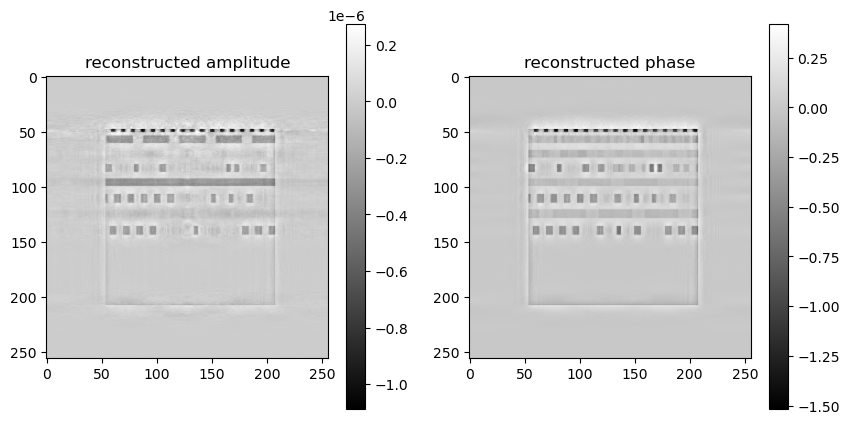

480/2048) rho=0.500000, 3.61e+03 8.34e+01 -5.38e-03 9.00e-03, Sum: 3.70e+03


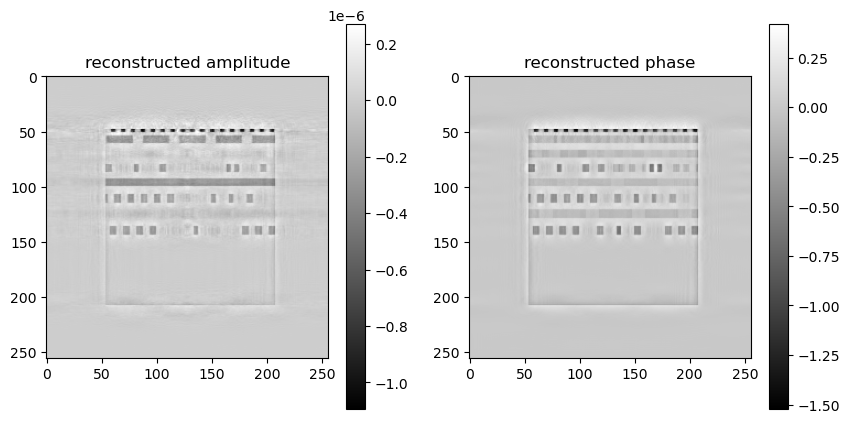

512/2048) rho=0.500000, 3.36e+03 7.97e+01 -4.33e-03 8.45e-03, Sum: 3.44e+03


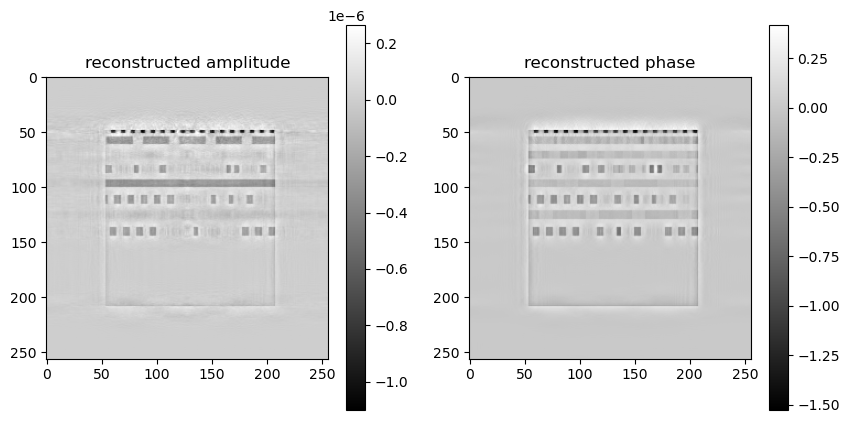

544/2048) rho=0.500000, 3.15e+03 7.66e+01 -7.77e-02 3.16e-02, Sum: 3.23e+03


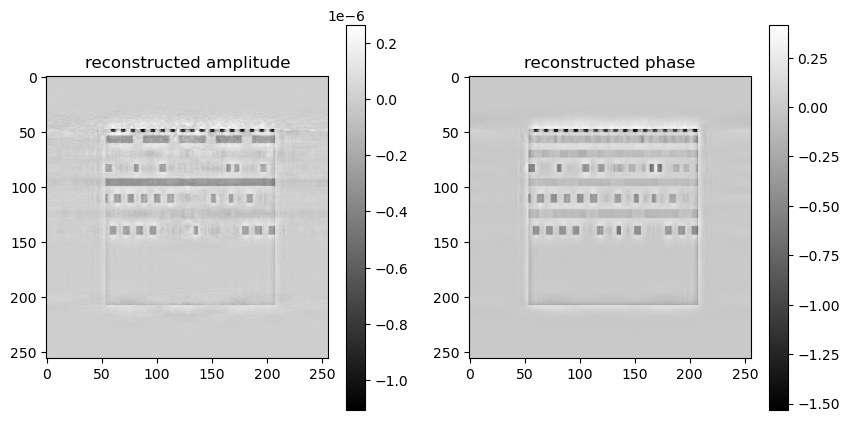

576/2048) rho=0.500000, 2.93e+03 7.39e+01 -2.82e-03 7.64e-03, Sum: 3.00e+03


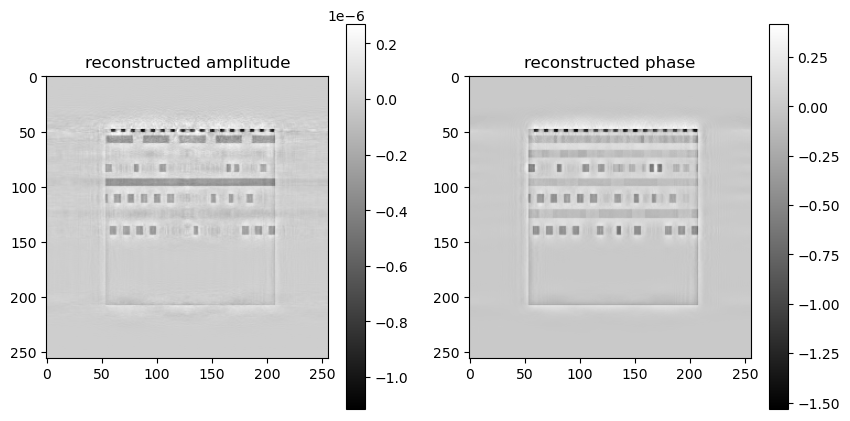

608/2048) rho=0.500000, 2.76e+03 7.15e+01 4.32e-02 1.67e-02, Sum: 2.84e+03


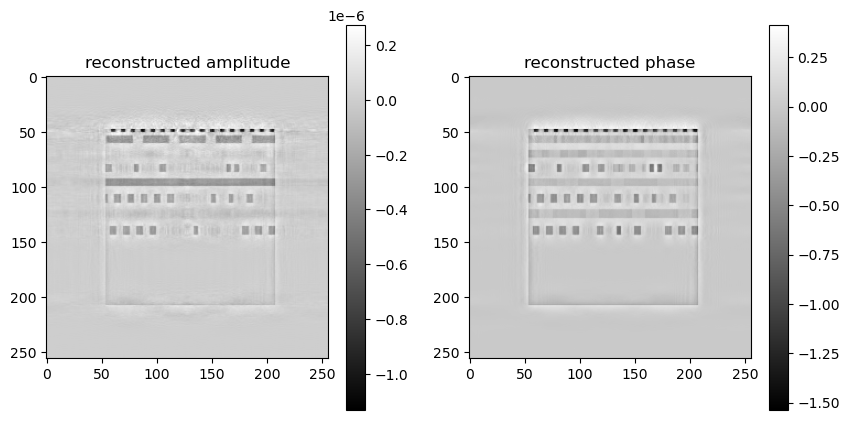

640/2048) rho=0.500000, 2.58e+03 6.95e+01 -1.59e-03 7.26e-03, Sum: 2.65e+03


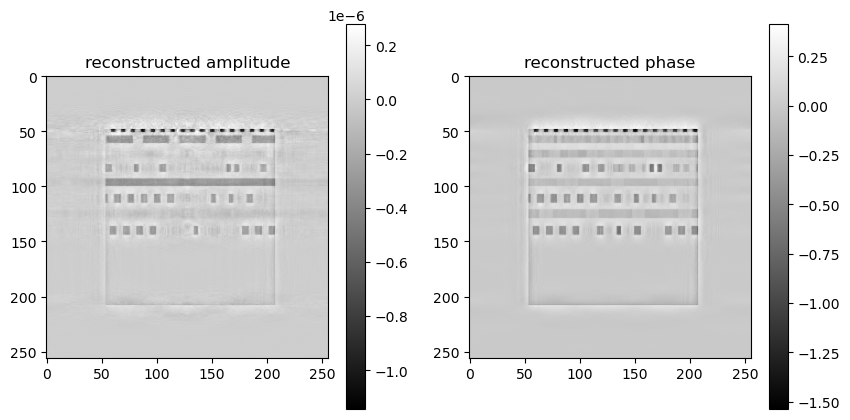

672/2048) rho=0.500000, 2.43e+03 6.76e+01 -1.56e-02 1.02e-02, Sum: 2.50e+03


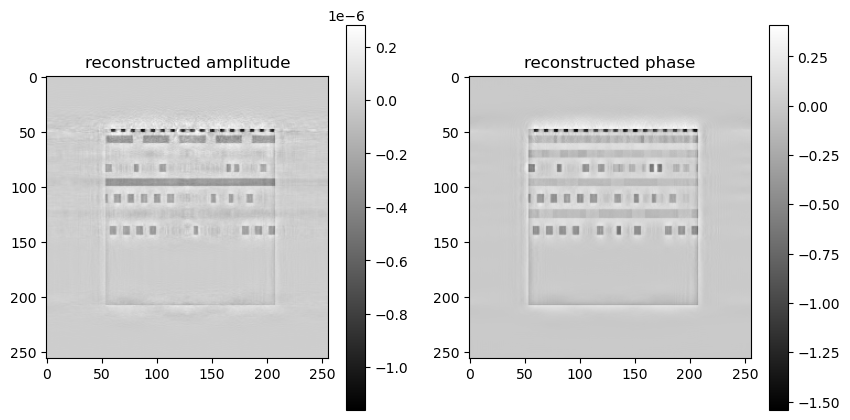

704/2048) rho=0.500000, 2.29e+03 6.59e+01 5.70e-03 7.47e-03, Sum: 2.35e+03


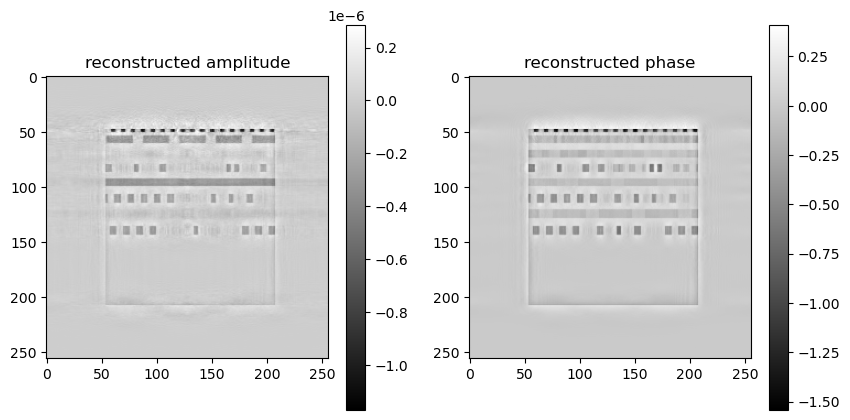

736/2048) rho=0.500000, 2.16e+03 6.44e+01 -4.26e-03 8.12e-03, Sum: 2.22e+03


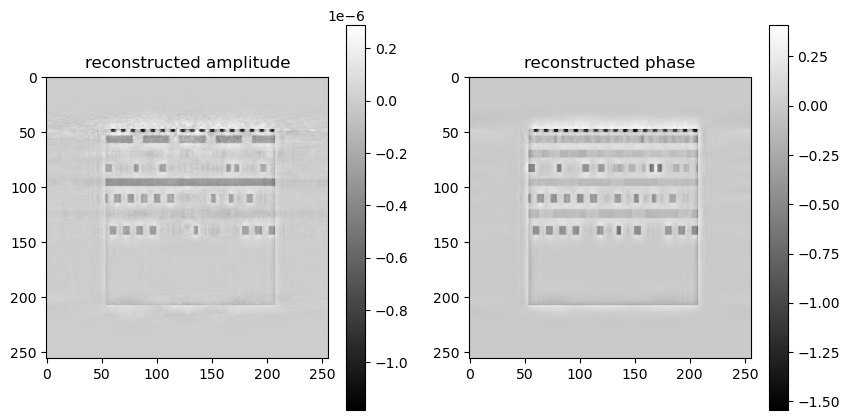

768/2048) rho=0.500000, 2.06e+03 6.30e+01 2.00e-02 1.15e-02, Sum: 2.12e+03


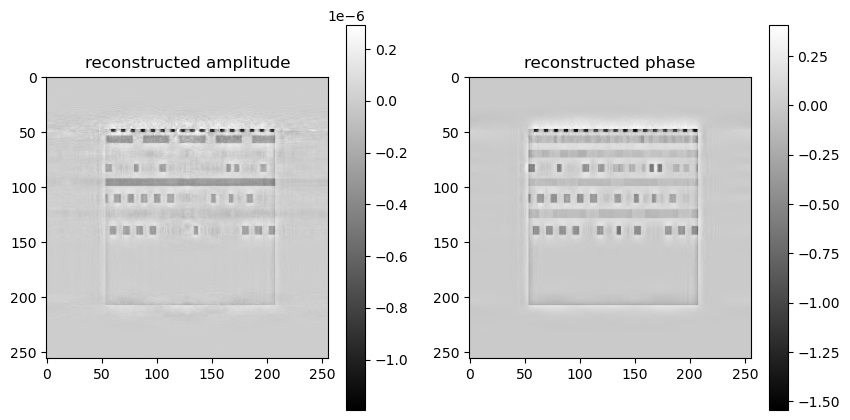

800/2048) rho=0.500000, 1.93e+03 6.17e+01 -1.08e-03 5.82e-03, Sum: 1.99e+03


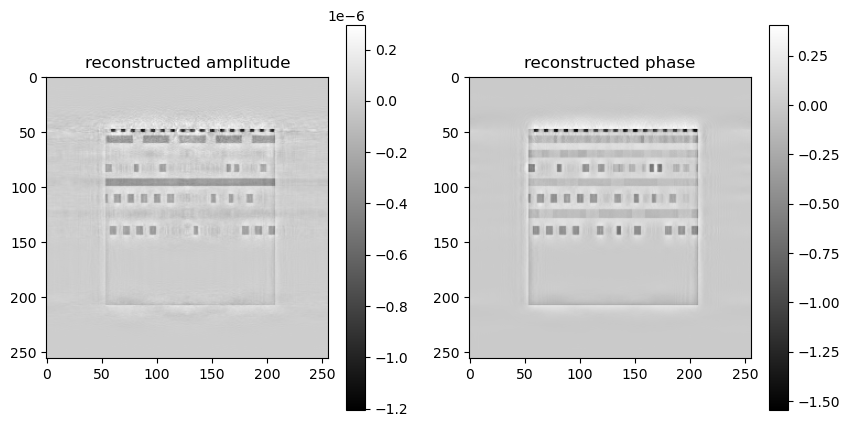

832/2048) rho=0.500000, 1.84e+03 6.05e+01 4.41e-03 1.28e-02, Sum: 1.90e+03


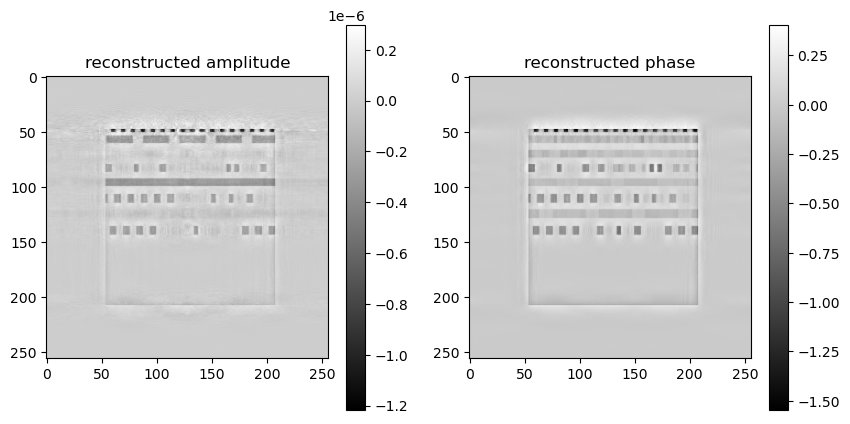

864/2048) rho=0.500000, 1.74e+03 5.94e+01 4.01e-03 5.67e-03, Sum: 1.80e+03


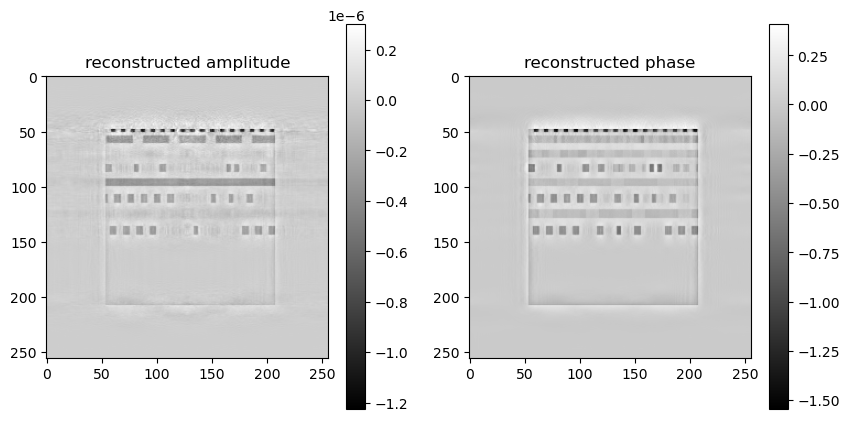

896/2048) rho=0.500000, 1.66e+03 5.83e+01 -6.29e-04 7.41e-03, Sum: 1.72e+03


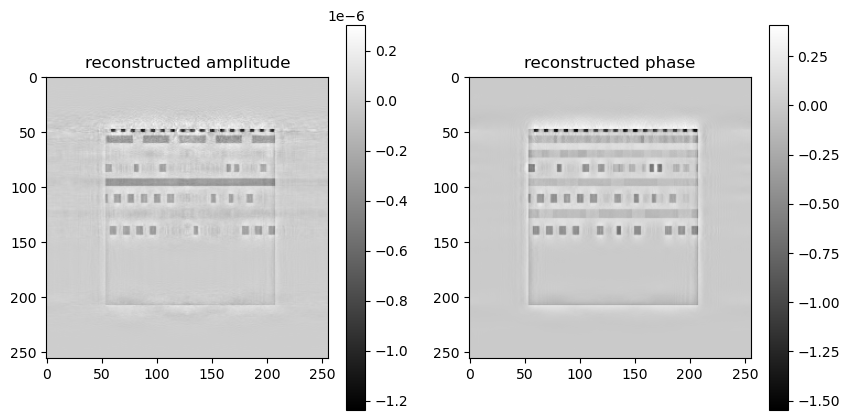

928/2048) rho=0.500000, 1.59e+03 5.73e+01 1.65e-02 7.22e-03, Sum: 1.64e+03


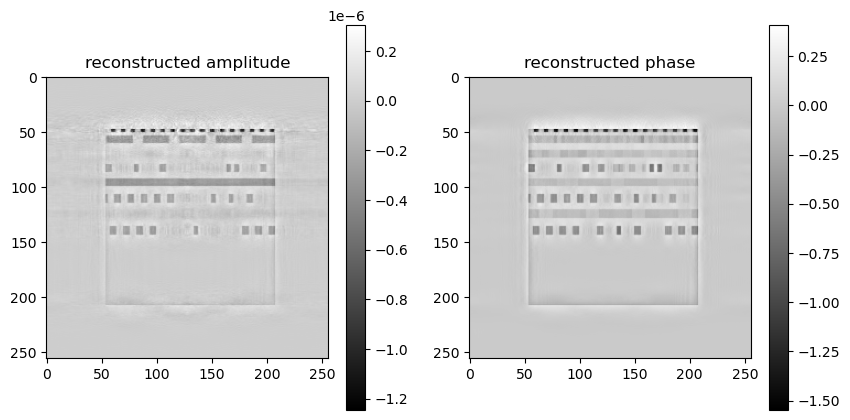

960/2048) rho=0.500000, 1.51e+03 5.64e+01 -2.99e-03 5.03e-03, Sum: 1.56e+03


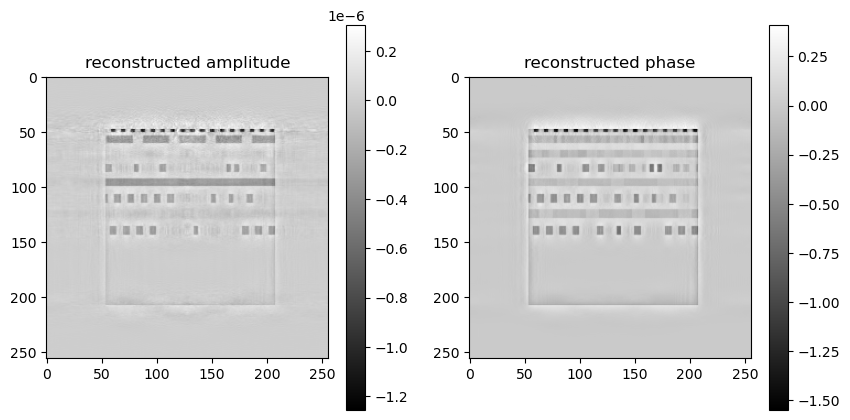

992/2048) rho=0.500000, 1.46e+03 5.55e+01 1.79e-02 8.54e-03, Sum: 1.51e+03


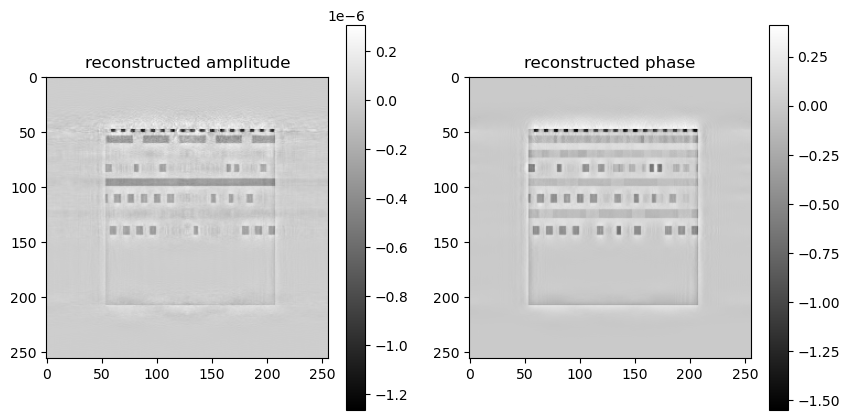

1024/2048) rho=0.500000, 1.38e+03 5.46e+01 -1.04e-03 4.06e-03, Sum: 1.43e+03


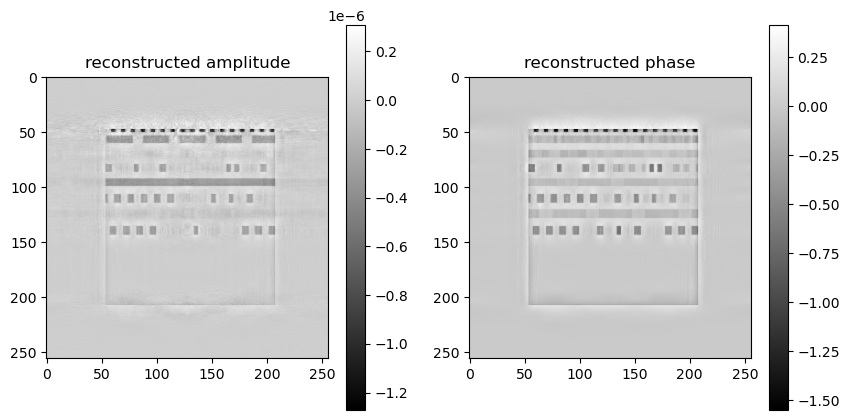

1056/2048) rho=0.500000, 1.33e+03 5.38e+01 -6.23e-03 6.17e-03, Sum: 1.39e+03


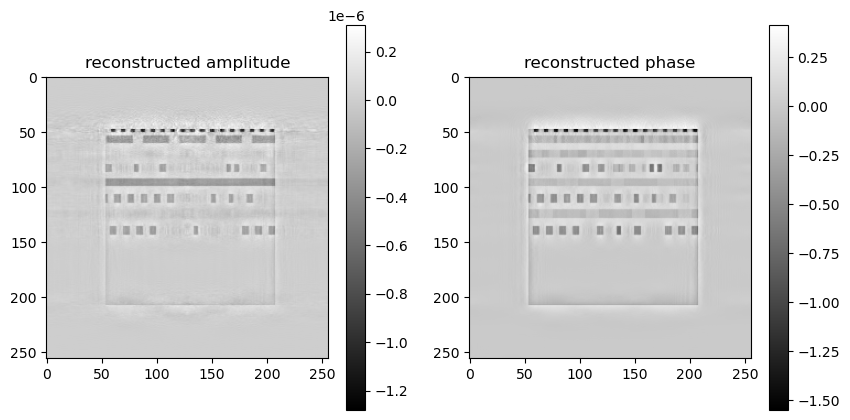

1088/2048) rho=0.500000, 1.26e+03 5.30e+01 -2.36e-04 3.55e-03, Sum: 1.32e+03


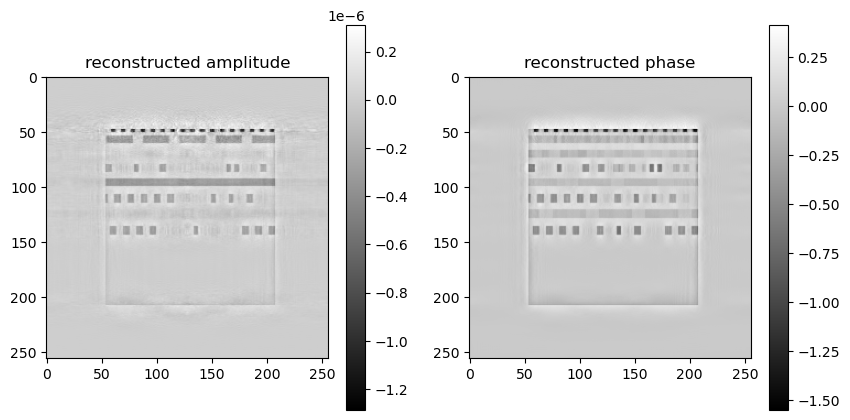

1120/2048) rho=0.500000, 1.22e+03 5.23e+01 -1.45e-02 5.33e-03, Sum: 1.28e+03


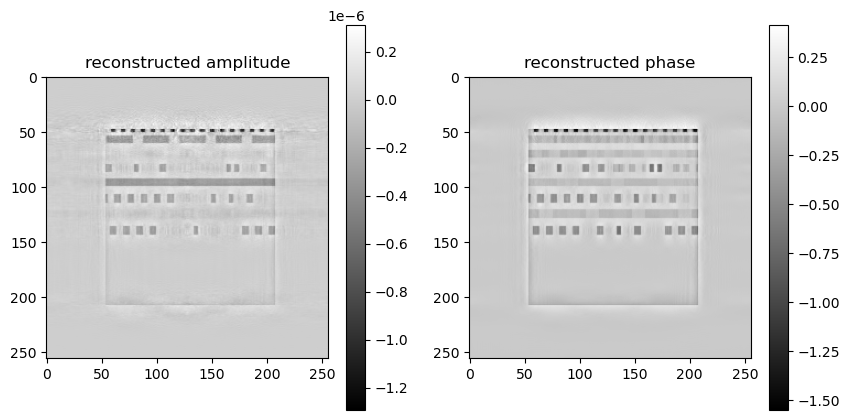

1152/2048) rho=0.500000, 1.16e+03 5.15e+01 -7.55e-06 3.16e-03, Sum: 1.22e+03


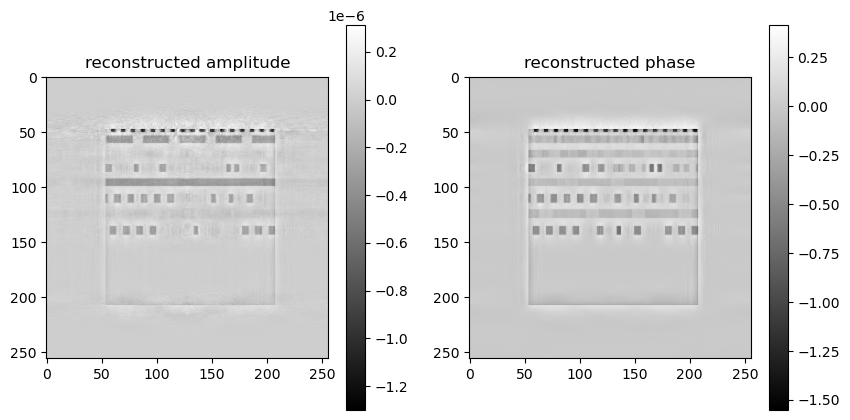

1184/2048) rho=0.500000, 1.13e+03 5.08e+01 -1.36e-02 4.88e-03, Sum: 1.18e+03


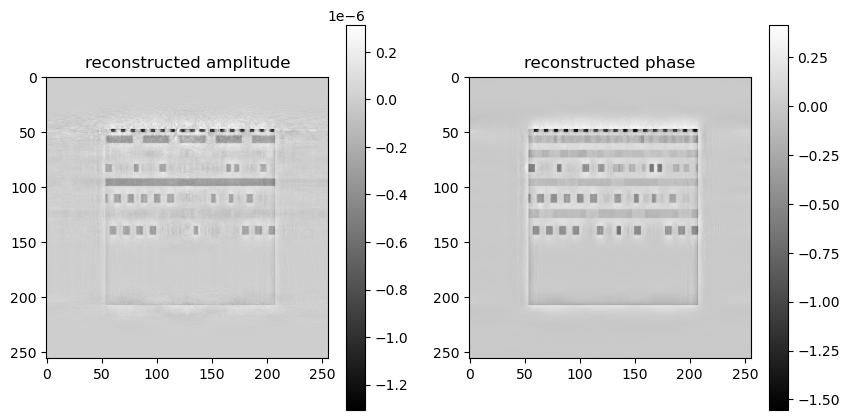

1216/2048) rho=0.500000, 1.08e+03 5.02e+01 -3.74e-05 2.86e-03, Sum: 1.13e+03


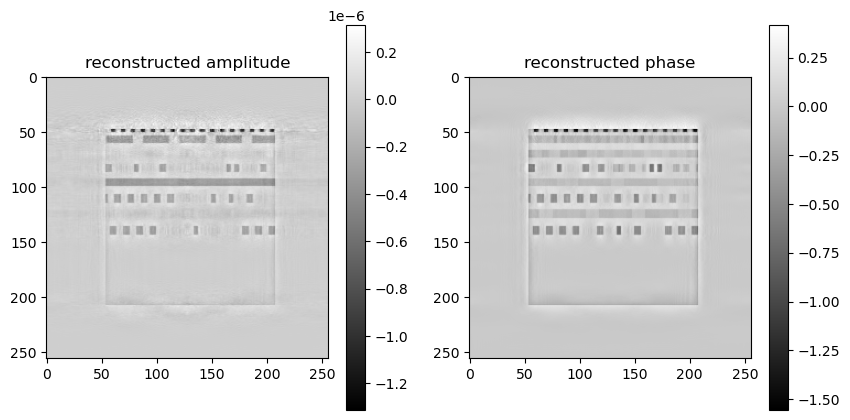

1248/2048) rho=0.500000, 1.05e+03 4.95e+01 -5.10e-03 4.75e-03, Sum: 1.10e+03


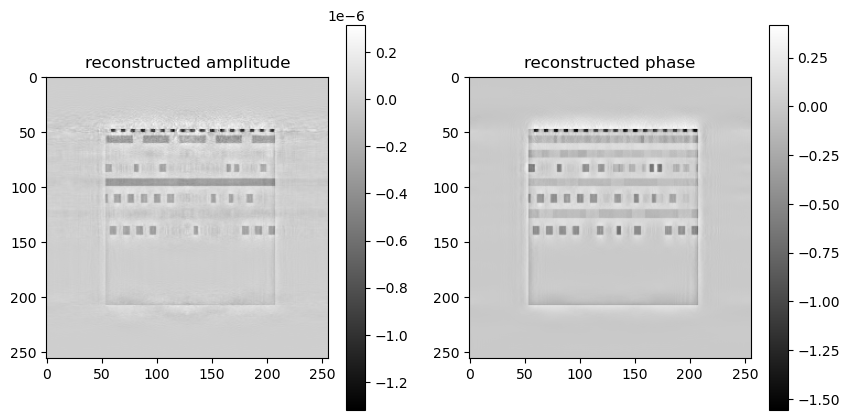

1280/2048) rho=0.500000, 1.00e+03 4.89e+01 -2.94e-04 2.62e-03, Sum: 1.05e+03


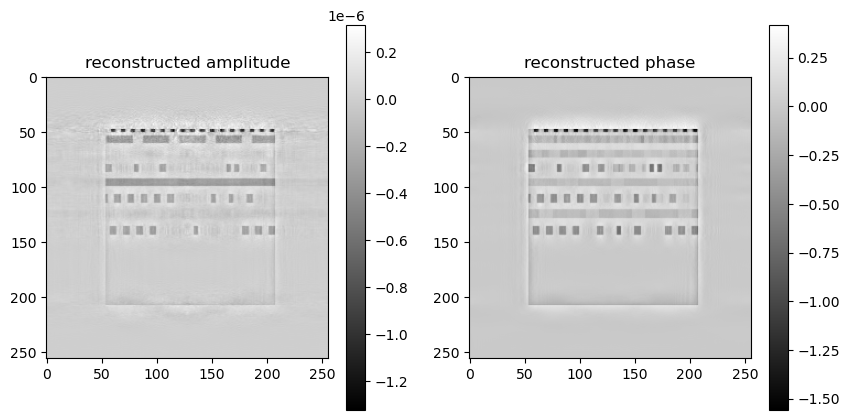

1312/2048) rho=0.500000, 9.82e+02 4.82e+01 1.29e-02 5.52e-03, Sum: 1.03e+03


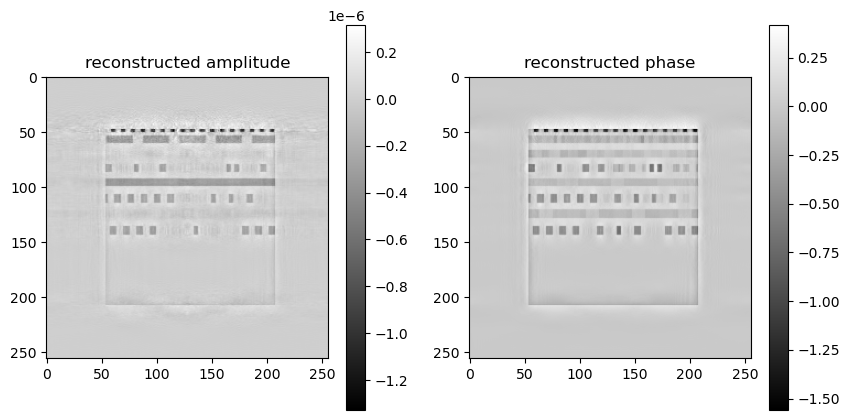

1344/2048) rho=0.500000, 9.34e+02 4.76e+01 -1.03e-03 2.51e-03, Sum: 9.81e+02


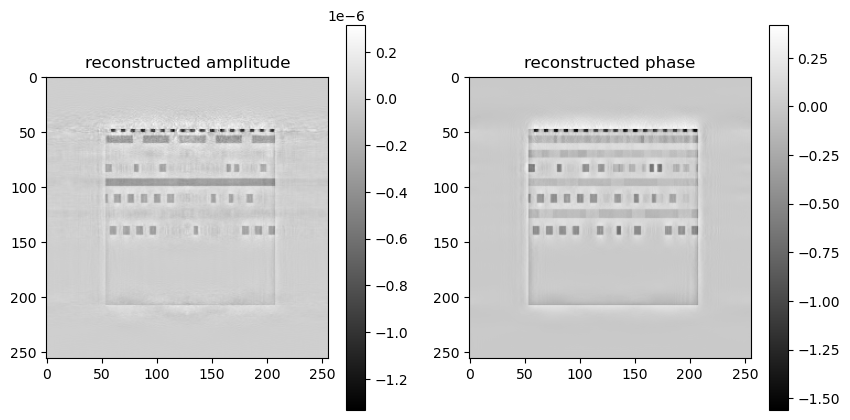

1376/2048) rho=0.500000, 9.12e+02 4.70e+01 1.34e-02 4.41e-03, Sum: 9.59e+02


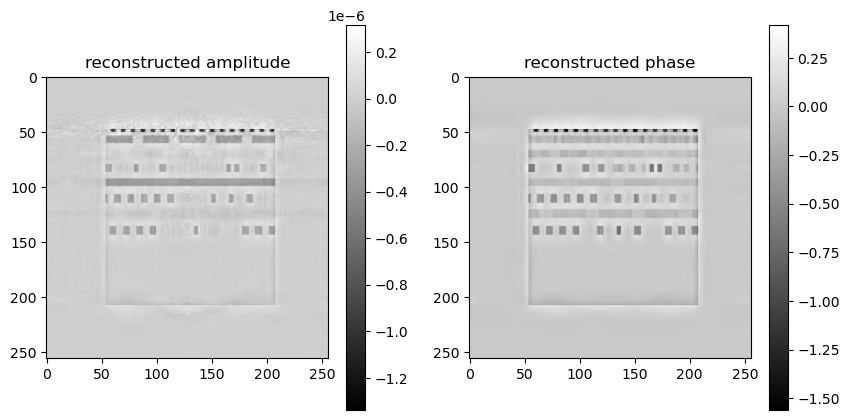

1408/2048) rho=0.500000, 8.74e+02 4.65e+01 -1.97e-03 2.73e-03, Sum: 9.20e+02


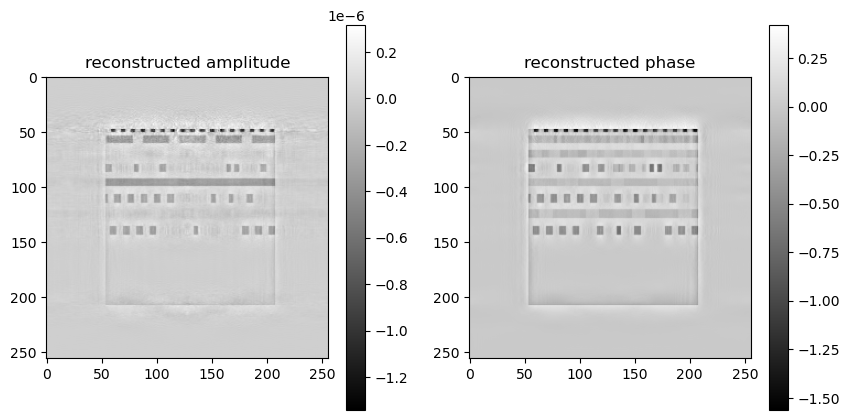

1440/2048) rho=0.500000, 8.48e+02 4.59e+01 3.36e-03 2.48e-03, Sum: 8.93e+02


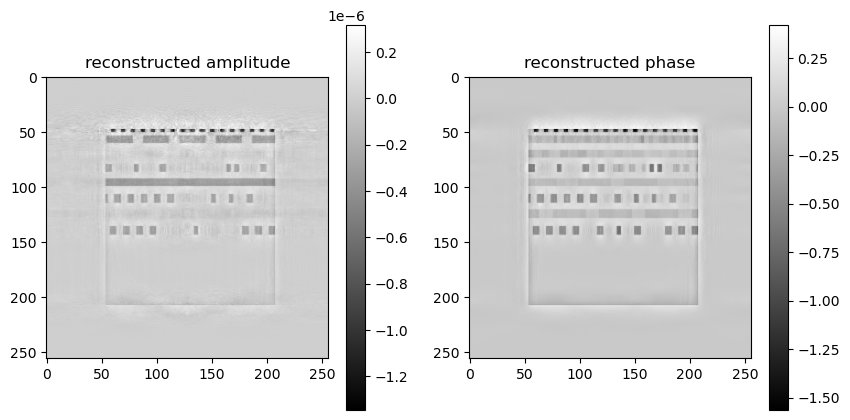

1472/2048) rho=0.500000, 8.20e+02 4.54e+01 3.80e-03 3.97e-03, Sum: 8.65e+02


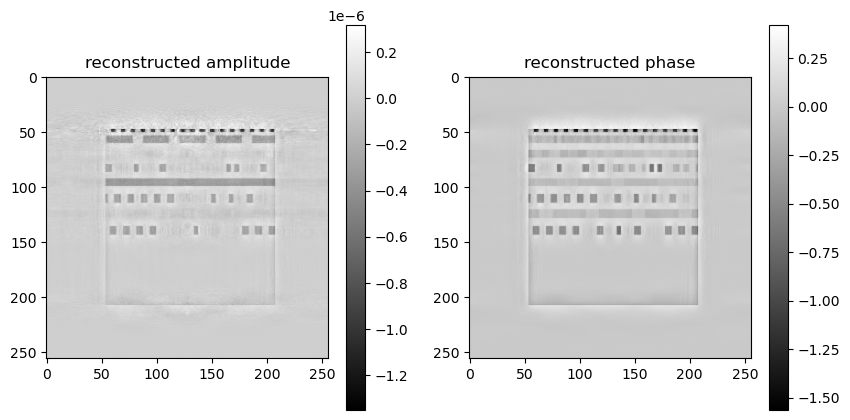

1504/2048) rho=0.500000, 7.93e+02 4.48e+01 4.71e-04 1.85e-03, Sum: 8.38e+02


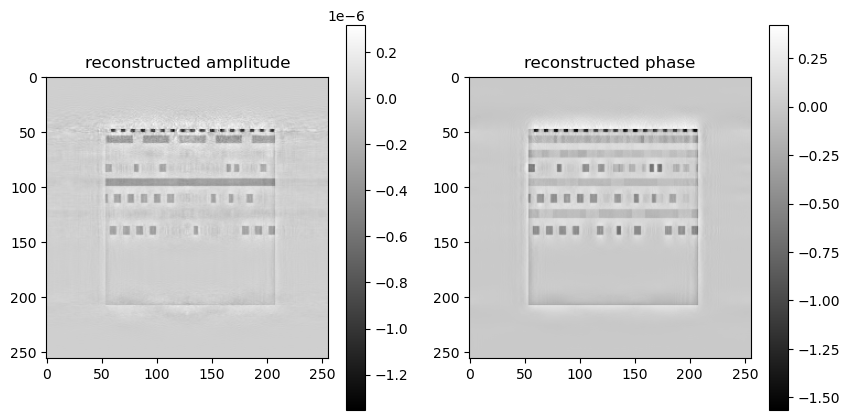

1536/2048) rho=0.500000, 7.74e+02 4.43e+01 -7.19e-04 5.08e-03, Sum: 8.18e+02


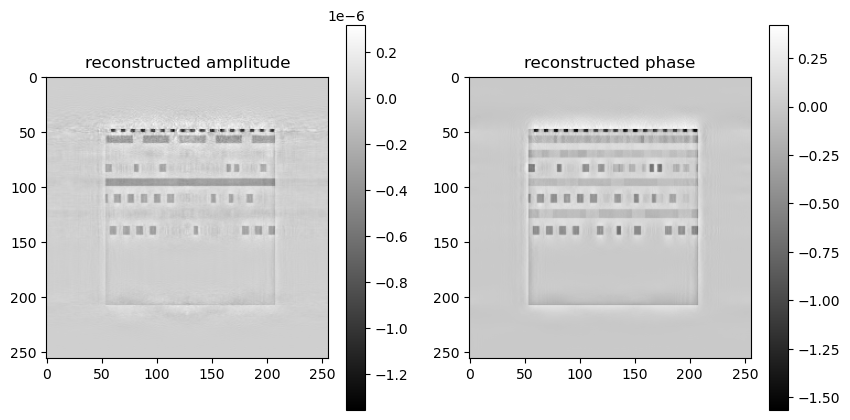

1568/2048) rho=0.500000, 7.46e+02 4.38e+01 1.79e-04 1.68e-03, Sum: 7.90e+02


In [13]:
tslv = holotomo.SolverTomo(theta, ntheta, ne, ne, pn*ne//n, center*ne//n)

xi = cp.array(pslv.logtomo(rec1))
ureg = cp.zeros([ne,ne,ne],dtype='complex64')
ureg = tslv.cg_tomo(xi,ureg,64,1)

dxchange.write_tiff(cp.imag(ureg).get(),      f'/data/vnikitin/modeling/chip_codes{flg}/uregim/r.tiff',overwrite=True)
dxchange.write_tiff(cp.imag(ureg[57*n//256]).get(), f'/data/vnikitin/modeling/chip_codes{flg}/uregim/o.tiff',overwrite=True)
dxchange.write_tiff(cp.real(ureg).get(),      f'/data/vnikitin/modeling/chip_codes{flg}/uregre/r.tiff',overwrite=True)
dxchange.write_tiff(cp.real(ureg[57*n//256]).get(), f'/data/vnikitin/modeling/chip_codes{flg}/uregre/o.tiff',overwrite=True)
dxchange.write_tiff(np.angle(rec1),   f'/data/vnikitin/modeling/chip_codes{flg}/psireg/r.tiff',overwrite=True)
dxchange.write_tiff(np.angle(rec1[0]),f'/data/vnikitin/modeling/chip_codes{flg}/psireg/o.tiff',overwrite=True)
            

h = cp.ones([ntheta,ne,ne],dtype='complex64')
lamd = cp.zeros([ntheta,ne,ne],dtype='complex64')
rec = cp.ones([ntheta,ne,ne],dtype='complex64')
rec_prb = cp.array(rec_prb0).copy()
urec = cp.zeros([ne,ne,ne],dtype='complex64')
data_gpu = cp.array(data)
data_ref_gpu = cp.array(data_ref)
shifts_gpu = cp.array(shifts)
code_gpu = cp.array(code)
shifts_code_gpu = cp.array(shifts_code)
    

urec, rec, rec_prb = admm_gpu(pslv, pslv0, tslv, data_gpu, data_ref_gpu, h, rec, rec_prb, shifts_gpu,code_gpu,shifts_code_gpu, lamd, urec, 16, 4, 2048,32,32)